## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint as pp

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, 
    average_precision_score, confusion_matrix,
    classification_report, roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier

In [4]:
def load_data(path):
    data = pd.read_csv(path, sep=" ", header=None)
    new_name = {i: f'att_{i+1}' for i in range(data.shape[1]-1)}
    new_name[data.shape[1]-1] = 'label'
    data.rename(columns=new_name, inplace=True)
    return data

In [5]:
TITLE_CONFIG = {'fontsize':14, 'fontweight':'bold'}
LABEL_CONFIG = {'fontsize':11}

## A. Data Preparation and Baseline

### 1. Load and Prepare Data

In [6]:
train = load_data('sat.trn')
train.head()

,att_1,att_2,att_3,att_4,att_5,att_6,att_7,att_8,att_9,att_10,...,att_28,att_29,att_30,att_31,att_32,att_33,att_34,att_35,att_36,label
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,3


In [7]:
label_to_text = {1: 'red soil', 2: 'cotton crop',
                 3: 'grey soil', 4: 'damp grey soil', 
                 5: 'soil with vegetation stubble',
                 7: 'very damp grey soil'}
text_to_label = {v:k for k,v in label_to_text.items()}
label_to_idx = {1:0, 2:1, 3:2, 4:3, 5:4, 7:5}
idx_to_label = {v:k for k,v in label_to_idx.items()}

In [8]:
print(f'Training data shape: {train.shape}')
print(f"There are {train.isnull().sum().sum()} null values in the training data.")

Training data shape: (4435, 37)
There are 0 null values in the training data.


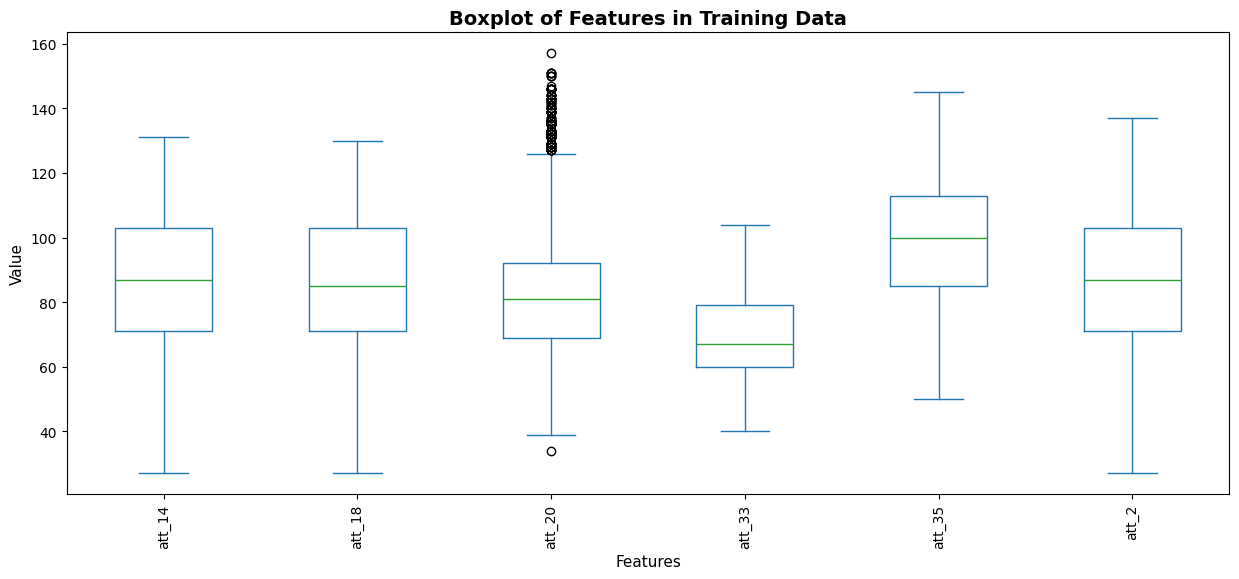

In [9]:
some_indices = np.random.randint(low=1, high=37, size=6)
train[[f"att_{idx}" for idx in some_indices]].plot(kind='box', figsize=(15, 6), rot=90)
plt.title('Boxplot of Features in Training Data', **TITLE_CONFIG)
plt.ylabel('Value', **LABEL_CONFIG)
plt.xlabel('Features', **LABEL_CONFIG)
plt.show()

In [10]:
train['label'].value_counts()

label
1    1072
7    1038
3     961
2     479
5     470
4     415
Name: count, dtype: int64

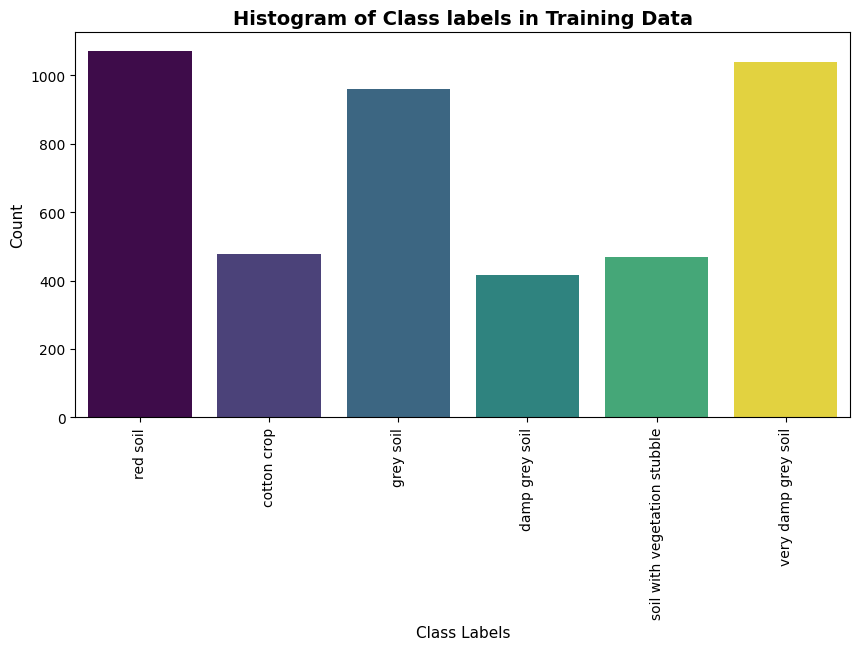

In [11]:
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=train, hue='label', palette='viridis', legend=False)
plt.title('Histogram of Class labels in Training Data', **TITLE_CONFIG)
plt.ylabel('Count', **LABEL_CONFIG)
plt.xlabel('Class Labels', **LABEL_CONFIG)
plt.xticks(ticks=np.arange(len(label_to_text)), labels=[label_to_text[i] for i in sorted(label_to_text.keys())], rotation=90)
plt.show()

In [12]:
test = load_data('sat.tst')
print(f'Testing data shape: {test.shape}')
print(f"There are {test.isnull().sum().sum()} null values in the testing data.")

Testing data shape: (2000, 37)
There are 0 null values in the testing data.


In [13]:
# data preprocessing
scaler = StandardScaler()
scaler.fit(train.drop(columns=['label']))
X = train.drop(columns=['label'])
y = train['label'].apply(lambda x: label_to_idx[x])

### 2. Train/Test Split

In [14]:
# apply scaling on training data
X_train_scaled, y_train = scaler.transform(X), y.copy()

In [15]:
# apply scaling on testing data
X_test = test.drop(columns=['label'])
y_test = test['label'].apply(lambda x: label_to_idx[x])
X_test_scaled = scaler.transform(X_test)

### 3. Train All Models

In [16]:
# let us also create an adverserial classifier
from sklearn.base import BaseEstimator, ClassifierMixin
class AdversarialClassifier(BaseEstimator, ClassifierMixin):
    """
    A wrapper that trains a base classifier but intentionally inverts
    the prediction probabilities (1 - P) to simulate adversarial performance (AUC < 0.5).
    """
    def __init__(self, base_estimator=LogisticRegression(random_state=1)):
        self.base_estimator = base_estimator
        self.classes_ = None

    def fit(self, X, y):
        # Train the base model normally
        self.base_estimator.fit(X, y)
        self.classes_ = self.base_estimator.classes_
        return self

    def predict_proba(self, X):
        # Get the standard probabilities from the base estimator (P)
        standard_proba = self.base_estimator.predict_proba(X)
        
        # INVERSION: Return 1 - P to simulate adversarial/inverted scoring
        # This forces the model to rank the correct class as the least likely, 
        # resulting in an AUC near 0.0.
        return 1.0 - standard_proba

    def predict(self, X):
        inverted_proba = self.predict_proba(X)
        # Find the index of the highest inverted probability (which is the lowest standard probability)
        # np.argmax returns the index of the maximum value along axis 1 (the class dimension)
        inverted_class_indices = np.argmax(inverted_proba, axis=1)
        # Map the index back to the actual class label
        return self.classes_[inverted_class_indices]

In [17]:
models = [
    # compulsory models
    DummyClassifier(strategy='prior'), 
    LogisticRegression(random_state=1), 
    KNeighborsClassifier(n_jobs=4), 
    DecisionTreeClassifier(random_state=1), 
    GaussianNB(), 
    SVC(probability=True, random_state=1),
    # brownie models
    DummyClassifier(strategy='uniform'),
    RandomForestClassifier(random_state=1, n_jobs=4), 
    XGBClassifier(random_state=1, n_jobs=4),
    GradientBoostingClassifier(random_state=1),
    MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(5, 2), random_state=1, max_iter=2000),
    AdversarialClassifier(base_estimator=LogisticRegression(random_state=1)),
]

In [18]:
def train_pipeline(models, X_train, y_train):
    trained_models = {}
    idx = 2
    for model in models:
        model_name = model.__class__.__name__
        model.fit(X_train, y_train)
        if model_name in trained_models:
            trained_models[f"{model_name}_v{idx}"] = model
            idx += 1
        else:
            trained_models[model_name] = model
            idx = 2
    return trained_models

def evaluate_models(trained_models, X_test, y_test):
    # we will calculate the overall accuracy and weighted F1-score for each model
    results = {}
    for model_name, model in trained_models.items():
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        results[model_name] = {
            'accuracy': report['accuracy'],
            'weighted_f1': report['weighted avg']['f1-score'],
            'macro_f1': report['macro avg']['f1-score'],
            'weighted_precision': report['weighted avg']['precision'],
            'macro_precision': report['macro avg']['precision'],
            'weighted_recall': report['weighted avg']['recall'],
            'macro_recall': report['macro avg']['recall']
        }
    return results

In [19]:
trained_models = train_pipeline(models, X_train_scaled, y_train)

In [20]:
# trained_models

### 4. Baseline Evaluation

In [21]:
results = evaluate_models(trained_models, X_test_scaled, y_test)

In [22]:
baseline_results_df = pd.DataFrame(results).T
baseline_results_df

,accuracy,weighted_f1,macro_f1,weighted_precision,macro_precision,weighted_recall,macro_recall
DummyClassifier,0.2305,0.086356,0.062441,0.053130,0.038417,0.2305,0.166667
LogisticRegression,0.8395,0.829595,0.797053,0.828262,0.811602,0.8395,0.793793
KNeighborsClassifier,0.9045,0.903748,0.891554,0.903495,0.895129,0.9045,0.888575
DecisionTreeClassifier,0.8510,0.851405,0.832266,0.852288,0.834552,0.8510,0.830599
GaussianNB,0.7965,0.803581,0.783276,0.816513,0.786370,0.7965,0.787733
SVC,0.8955,0.892490,0.876917,0.892368,0.885214,0.8955,0.872379
DummyClassifier_v2,0.1650,0.169501,0.158331,0.180815,0.161892,0.1650,0.162024
RandomForestClassifier,0.9055,0.903579,0.891403,0.903550,0.898893,0.9055,0.886450
XGBClassifier,0.9050,0.902956,0.888581,0.902876,0.896141,0.9050,0.883717
GradientBoostingClassifier,0.8920,0.890594,0.874886,0.889875,0.878960,0.8920,0.871716


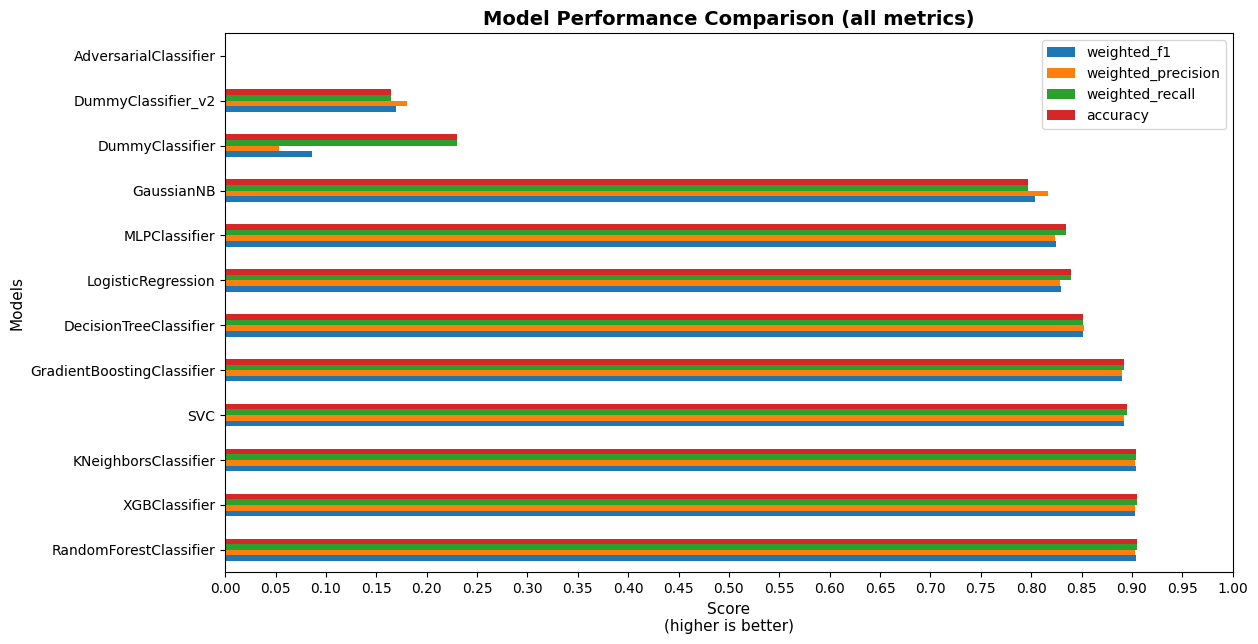

In [23]:
baseline_results_df[['weighted_f1', 'weighted_precision', 'weighted_recall', 'accuracy']].sort_values(by='accuracy', ascending=False).plot(figsize=(13,7), kind='barh')
plt.title('Model Performance Comparison (all metrics)', **TITLE_CONFIG)
plt.xlabel('Score\n(higher is better)', **LABEL_CONFIG)
plt.ylabel('Models', **LABEL_CONFIG)
plt.xticks(ticks=[i for i in np.arange(0, 1.05, 0.05)], rotation=0)
plt.show()

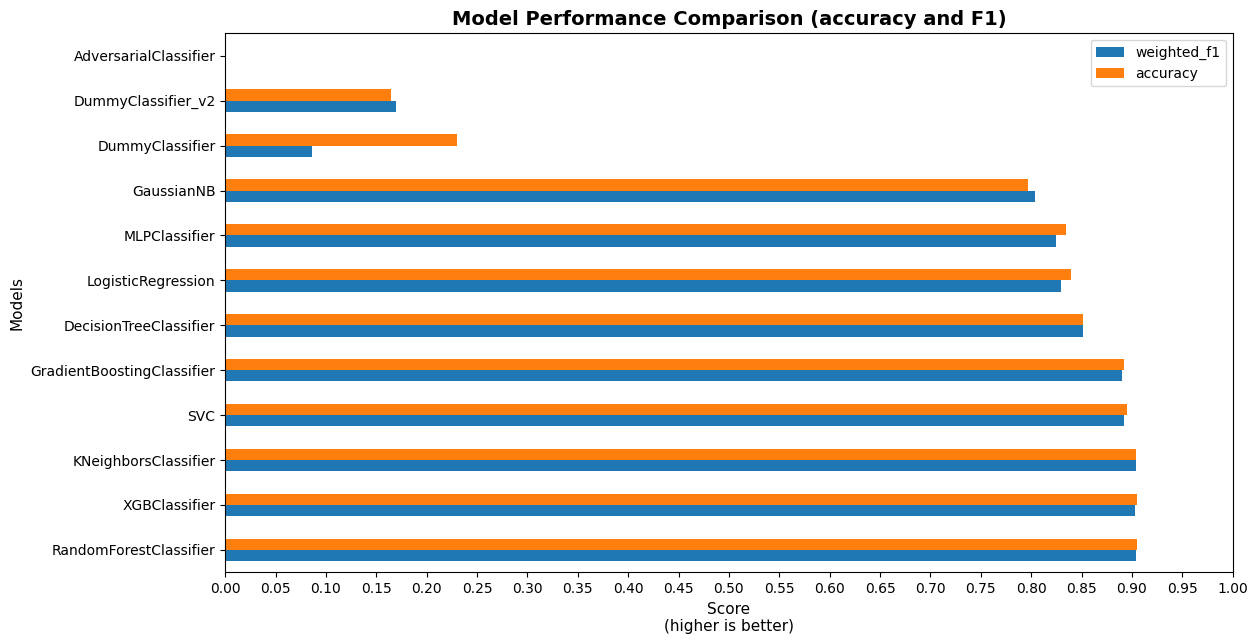

In [24]:
baseline_results_df[['weighted_f1', 'accuracy']].sort_values(by='accuracy', ascending=False).plot(figsize=(13,7), kind='barh')
plt.title('Model Performance Comparison (accuracy and F1)', **TITLE_CONFIG)
plt.xlabel('Score\n(higher is better)', **LABEL_CONFIG)
plt.ylabel('Models', **LABEL_CONFIG)
plt.xticks(ticks=[i for i in np.arange(0, 1.05, 0.05)], rotation=0)
plt.show()

As, expected our `AdverserialClassifier` has performed the worst. But let us check amongst the normal classifiers.

* **`DummyClassifier(strategy="uniform")` (v2):** This makes a purely random guess among all classes, assuming each has an equal chance. Since we have **6** different classes, a completely random guess will be right, on average, 1 out of 6 times (1/6 $\approx$ 0.167).`DummyClassifier_v2` has an accuracy of ~0.17, showing it's working exactly as designed, it's just guessing.

* **`DummyClassifier(strategy="prior")`:** This does a "little educated guessing," as it considers the class frequencies in the training data. The `predict_proba()` will return this same set of probabilities `[0.242, 0.234, ...]` for every single sample. When `predict()` is called, it makes a **weighted random guess** based on these fixed probabilities. It will guess the most frequent class (label '1') about 24.2% of the time, label '7' about 23.4% of the time, and so on. This is slightly better than pure random guessing (which is why 0.23 > 0.17), but its performance is still low for a critical reason.

**Both strategies completely ignore your input features (X)**. Their predictions are based *only* on the distribution of the target labels (y) in your training set.

## B. ROC Analysis for Model Selection

### 1. Multi-Class ROC Calculation

The core idea of the **OvR** strategy is to train a **separate binary classifier** for **each class**. For a given class, that class becomes the "positive" class, and all other classes are grouped together to form the "negative" class. This process is *repeated* for every class in the dataset.

In [25]:
def generate_roc_curves(trained_models, X_test, y_test, n_classes):
    roc_data = {}
    for model_name, model in trained_models.items():
        y_score = model.predict_proba(X_test)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for class_idx in range(n_classes):
            fpr[class_idx], tpr[class_idx], _ = roc_curve((y_test == class_idx).astype(int), y_score[:, class_idx])
            # roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx]) # alternate way to calculate AUC
            roc_auc[class_idx] = roc_auc_score((y_test == class_idx).astype(int), y_score[:, class_idx])
        roc_data[model_name] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}
    return roc_data

def plot_roc_curves(roc_data, n_classes):
    n_models = len(roc_data)
    n_cols = 3
    fig, axes = plt.subplots(figsize=(20, 22), nrows=(n_models+1) // n_cols, ncols=n_cols)
    for ax, (model_name, data) in zip(axes.flatten(), roc_data.items()):
        for class_idx in range(n_classes):
            ax.plot(data['fpr'][class_idx], data['tpr'][class_idx],
                     label=f'Class {idx_to_label[class_idx]} (AUC = {data["roc_auc"][class_idx]:.2f})')
        ax.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
        ax.set_title(f'ROC Curves for {model_name}', **TITLE_CONFIG)
        ax.set_xlabel('False Positive Rate', **LABEL_CONFIG)
        ax.set_ylabel('True Positive Rate', **LABEL_CONFIG)
        ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [26]:
n_classes = len(label_to_idx)
roc_data = generate_roc_curves(trained_models, X_test_scaled, y_test, n_classes)

```python
label_mapping = {
    1: 'red soil',
    2: 'cotton crop',
    3: 'grey soil',
    4: 'damp grey soil',
    5: 'soil with vegetation stubble',
    7: 'very damp grey soil'
}
```

### 2. Plotting ROC

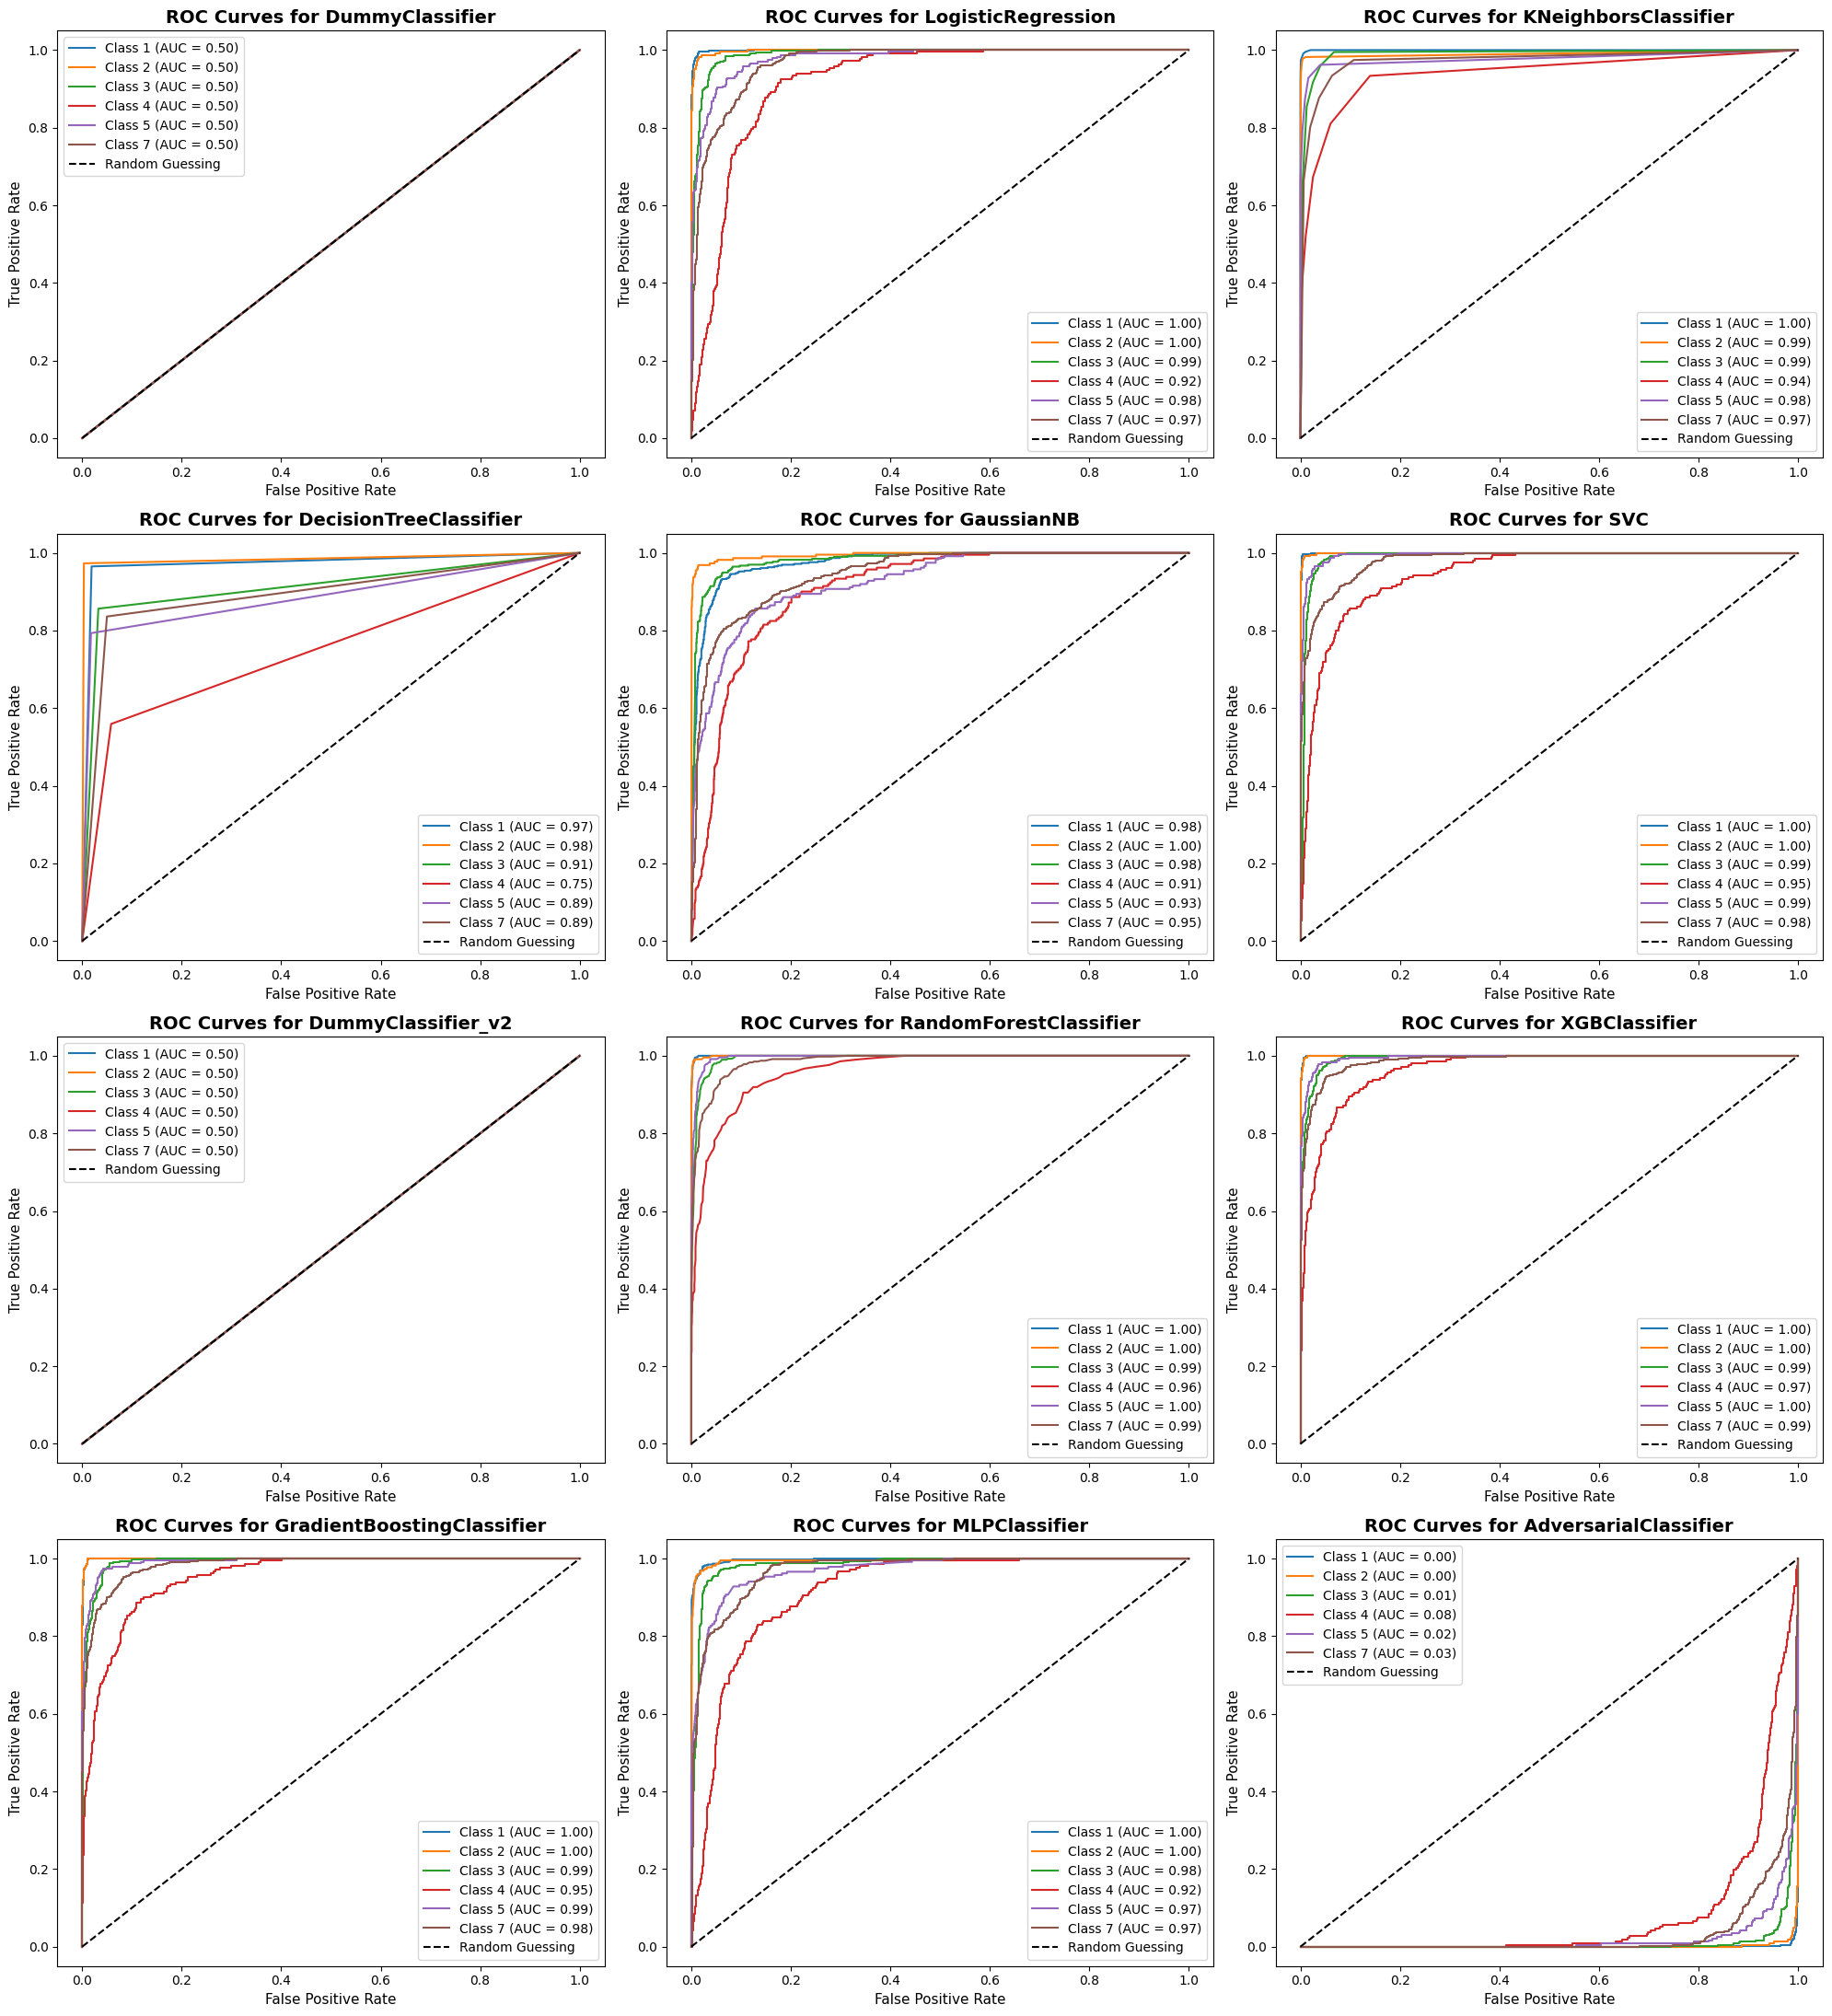

In [27]:
plot_roc_curves(roc_data, n_classes)

`AdverserialClassifier` has very less scores across all the classed amongst all models.

Almost all models perform good (except above) ROC-AUC wise per-class. `DecisionTreeClassifier` and `SGDClassifier` had a lower ROC-AUC for class `4` (minority class).

#### Macro-Average
The **macro-average** computes the metric (like precision, recall, or F1-score) for each class *independently* and then takes the simple, *unweighted* average of these per-class scores.

* **Key Idea:** It **treats all classes equally**, regardless of how many samples they have. A rare class's score counts just as much as a common class's score.
* **Use When:** We want to evaluate how the model performs *on average across all classes*, especially if you care about good performance even on the infrequent ones.

#### Weighted-Average
The **weighted-average** also computes the metric for each class *independently*. However, when it calculates the final average, it uses a *weighted* average. The weight for each class's score is its **support** (the number of samples in that class).

* **Key Idea:** It **accounts for class imbalance**. Classes with more samples have a greater influence on the final score.
* **Use When:** We want a score that reflects the model's performance across the *entire dataset* and is proportional to how common each class is.

In [28]:
def macro_average_class_roc_data(roc_data, n_classes):
    # let us combine TPR and FPR across classes for each model using macro-averaging
    combined_roc_data = {}
    for model_name, data in roc_data.items():
        # we find out average TPR at each FPR point
        all_fprs = np.unique(np.concatenate([list(data['fpr'][i]) + [0.0, 1.0] for i in range(n_classes)] ))
        mean_tpr = np.zeros_like(all_fprs)
        for class_idx in range(n_classes):
            # interpolate TPR at all FPR points
            mean_tpr += np.interp(all_fprs, data['fpr'][class_idx], data['tpr'][class_idx])
        mean_tpr /= n_classes
        combined_roc_data[model_name] = {'fpr': all_fprs, 'tpr': mean_tpr, 'roc_auc': auc(all_fprs, mean_tpr)}
    return combined_roc_data

def weighted_average_class_roc_data(roc_data, label_value_counts):
    n_classes = len(label_value_counts)
    total_samples = sum(label_value_counts.values())
    # let us combine TPR and FPR across classes for each model using weighted-averaging
    combined_roc_data = {}
    for model_name, data in roc_data.items():
        # we find out average TPR at each FPR point
        all_fprs = np.unique(np.concatenate([list(data['fpr'][i]) + [0.0, 1.0] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fprs)
        for class_idx in range(n_classes):
            weight = label_value_counts[class_idx] / total_samples
            # interpolate TPR at all FPR points
            mean_tpr += weight * np.interp(all_fprs, data['fpr'][class_idx], data['tpr'][class_idx])
        combined_roc_data[model_name] = {'fpr': all_fprs, 'tpr': mean_tpr, 'roc_auc': auc(all_fprs, mean_tpr)}
    return combined_roc_data

In [29]:
macro_avg_roc_data = macro_average_class_roc_data(roc_data, n_classes)
label_value_counts = y_test.value_counts().to_dict()
weighted_avg_roc_data = weighted_average_class_roc_data(roc_data, label_value_counts)

In [30]:
def plot_roc_curve(ma_combined_roc_data, wa_combined_roc_data, sup_title=None):
    n_models = len(ma_combined_roc_data)
    n_cols = 3
    fig, axes = plt.subplots(figsize=(20, 22), nrows=(n_models+1) // n_cols, ncols=n_cols)
    for ax, (model_name, data1), (_, data2) in zip(axes.flatten(), ma_combined_roc_data.items(), wa_combined_roc_data.items()):
        ax.plot(data1['fpr'], data1['tpr'], label=f'Macro-avg AUC = {data1["roc_auc"]:.2f}')
        ax.plot(data2['fpr'], data2['tpr'], label=f'Weighted-avg AUC = {data2["roc_auc"]:.2f}')
        ax.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
        ax.set_title(f'ROC Curve for {model_name}', **TITLE_CONFIG)
        ax.set_xlabel('False Positive Rate', **LABEL_CONFIG)
        ax.set_ylabel('True Positive Rate', **LABEL_CONFIG)
        ax.legend(loc='best')
    if sup_title:
        plt.suptitle(sup_title, **{'fontsize':20, 'fontweight':'bold'}, y=1.02)
    plt.tight_layout()
    plt.show()

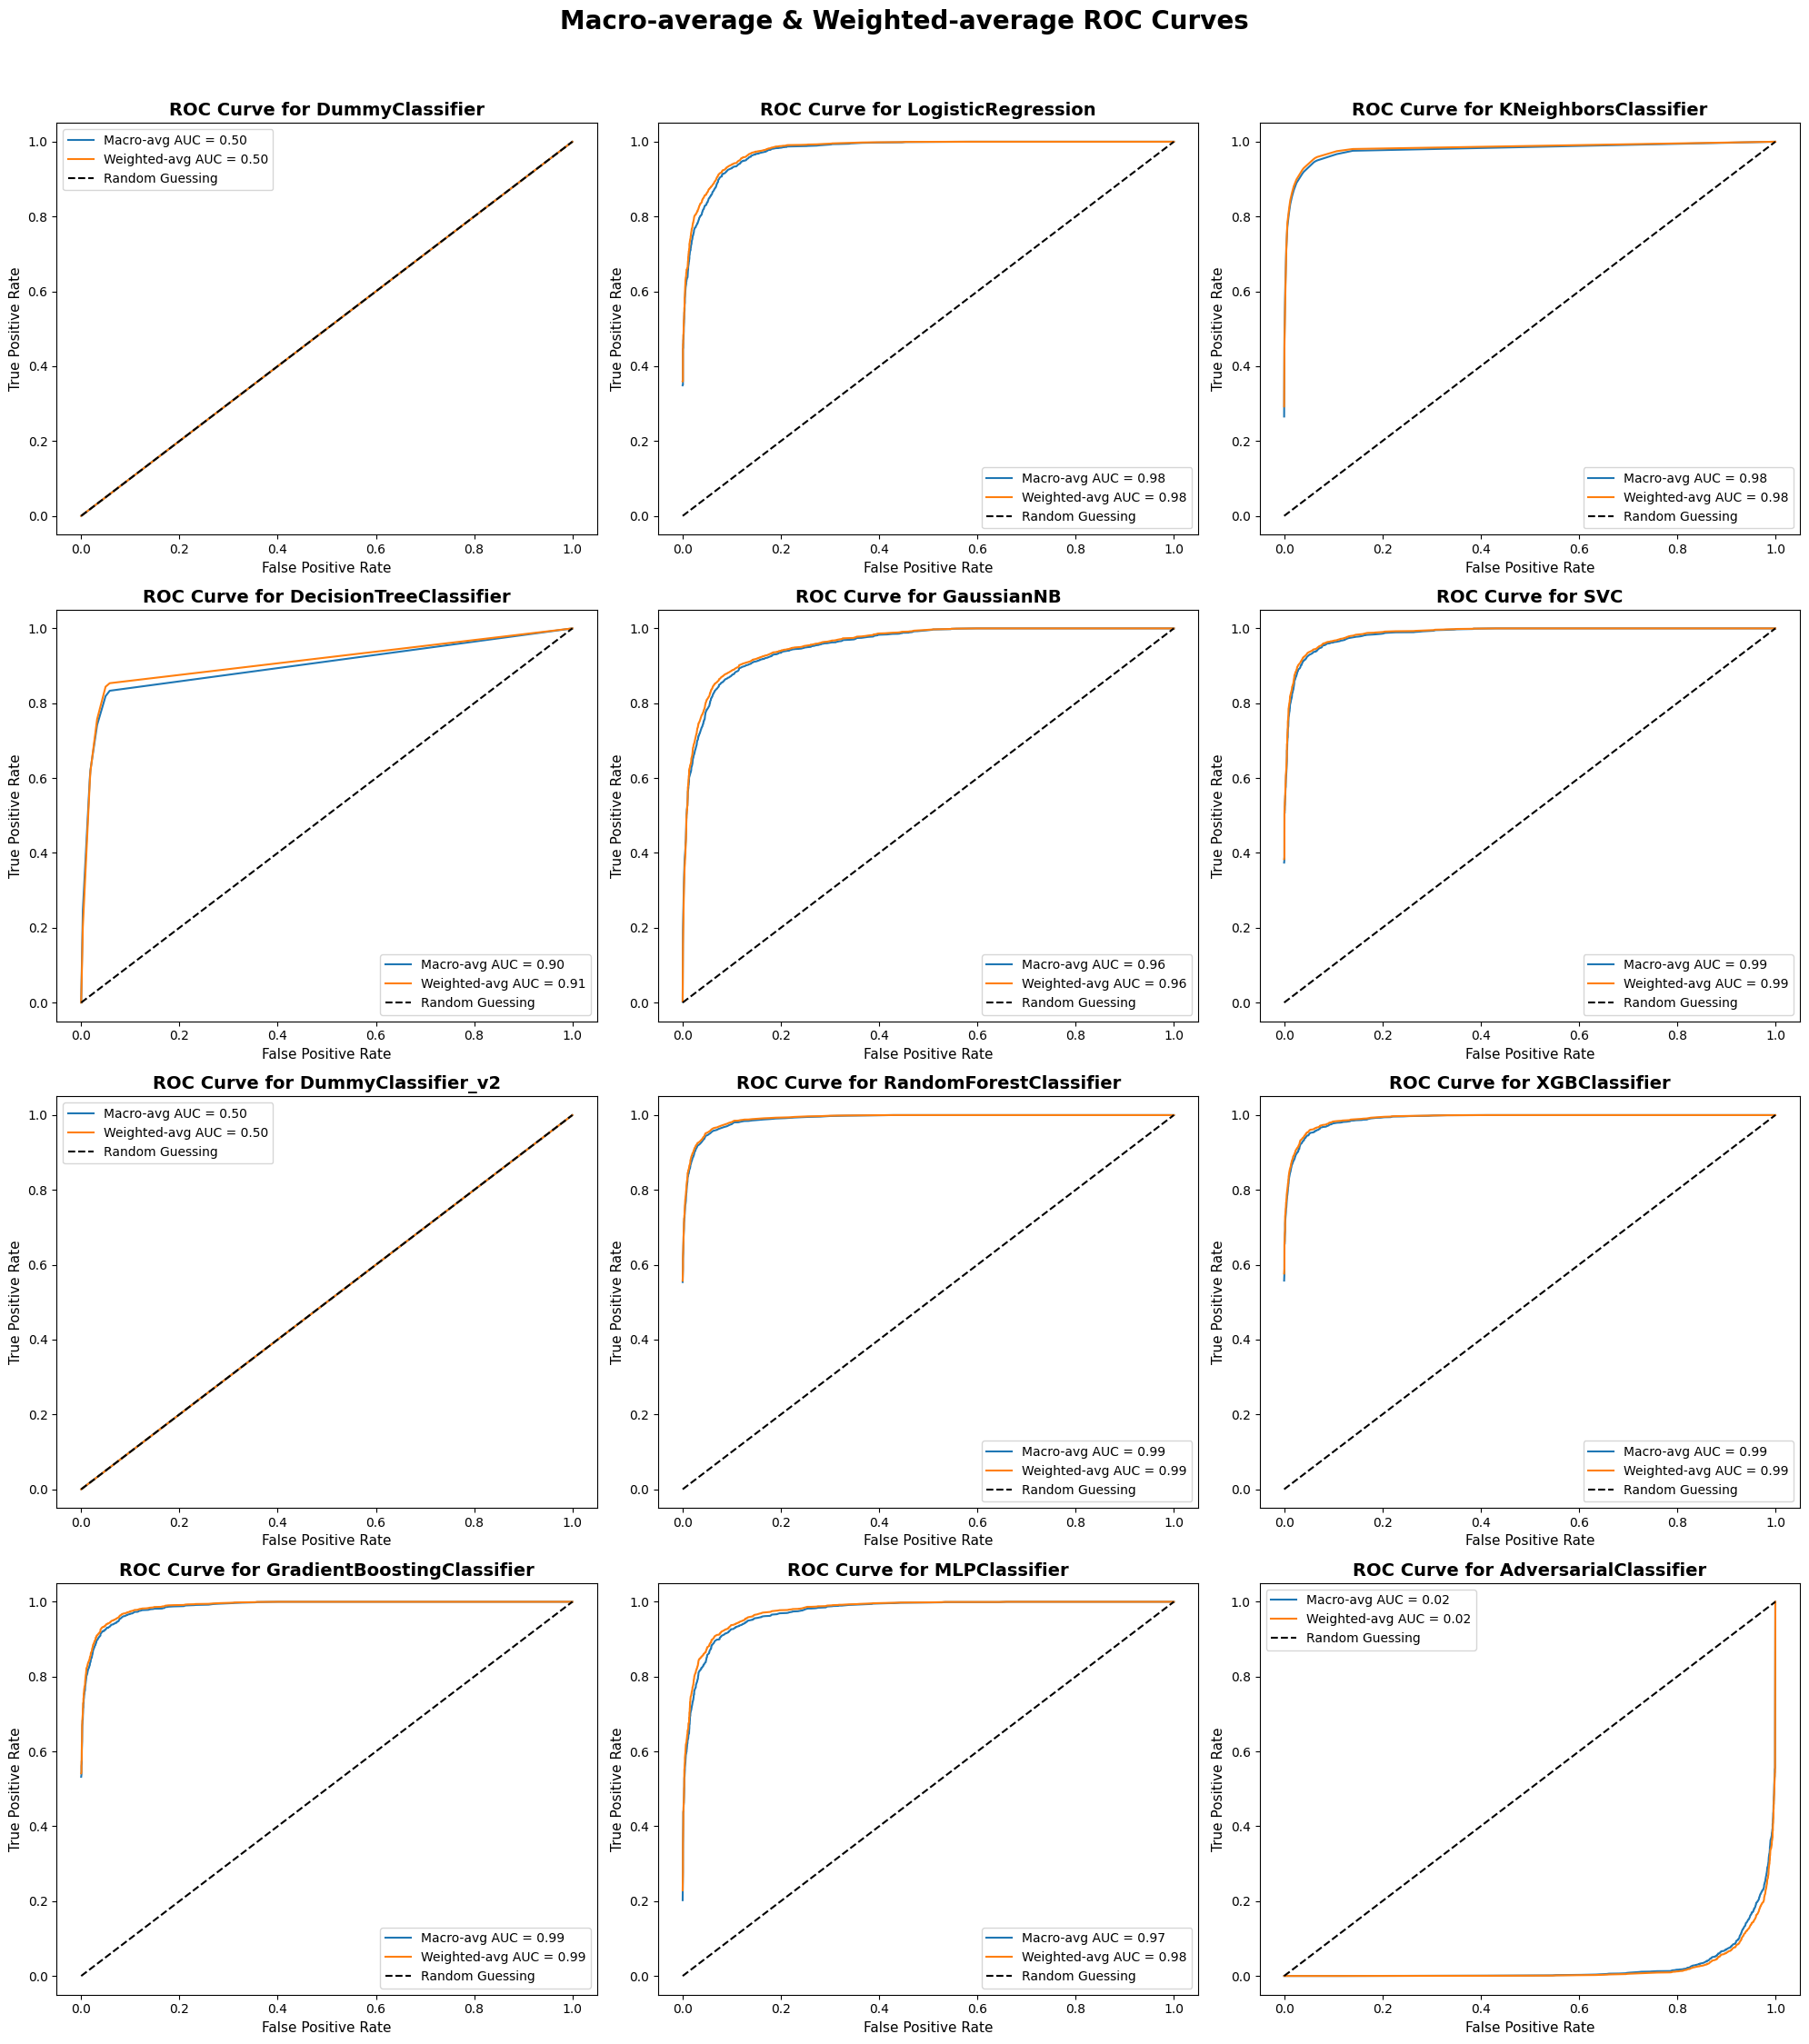

In [31]:
plot_roc_curve(macro_avg_roc_data, weighted_avg_roc_data, sup_title='Macro-average & Weighted-average ROC Curves')

This plot confirms that the top-tier models (`XGBClassifier`, `RandomForest`, `SVC`) achieve near-perfect averaged performance, with AUCs $\approx$ 0.99. The Macro-average and Weighted-average lines are almost identical for every model, suggesting that class imbalance is not a significant factor in their performance. The `DummyClassifier` (0.50) and `AdversarialClassifier` (0.02) correctly establish the performance floor and inverted-logic baseline.

### 3. ROC Interpretation

In [32]:
roc_aucs_dict = {}
for model_name, metrics in macro_avg_roc_data.items():
    if not roc_aucs_dict.get("Model", None):
        roc_aucs_dict["Model"] = []
    if not roc_aucs_dict.get("ROC-AUC Score", None):
        roc_aucs_dict["ROC-AUC Score"] = []
    roc_aucs_dict["Model"].append(model_name)
    roc_aucs_dict["ROC-AUC Score"].append(metrics['roc_auc'])
roc_aucs_df = pd.DataFrame(roc_aucs_dict)

In [33]:
roc_aucs_df.sort_values(by="ROC-AUC Score", ascending=False)

,Model,ROC-AUC Score
8,XGBClassifier,0.990153
7,RandomForestClassifier,0.989663
9,GradientBoostingClassifier,0.986796
5,SVC,0.985183
2,KNeighborsClassifier,0.978567
1,LogisticRegression,0.975742
10,MLPClassifier,0.973094
4,GaussianNB,0.955347
3,DecisionTreeClassifier,0.900295
0,DummyClassifier,0.500000


`XGBClassifier` achieves the highest **macro average AUC** score of $\approx$ **0.9902**, while `RandomForestClassifier` is not **far behind** with score of $\approx$ **0.9897**.

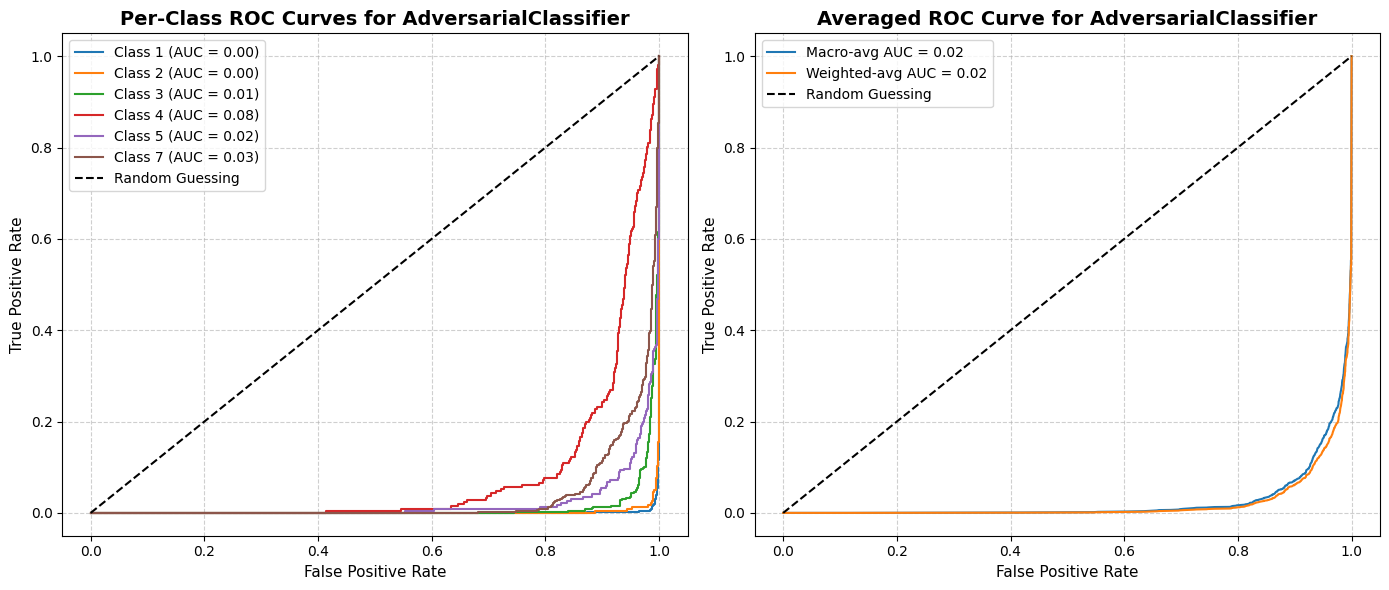

In [34]:
# checking the adverserial classifier again!
adv_model = AdversarialClassifier()
adv_model.fit(X_train_scaled, y_train)
adv_model_pred_prob = adv_model.predict_proba(X_test_scaled)
fpr_adv = dict()
tpr_adv = dict()
roc_auc_adv = dict()

for i in range(n_classes):
    y_test_binary = (y_test == i).astype(int)
    y_score = adv_model_pred_prob[:, i] 
    fpr, tpr, _ = roc_curve(y_test_binary, y_score)
    fpr_adv[i] = fpr
    tpr_adv[i] = tpr
    roc_auc_adv[i] = auc(fpr, tpr)
class_labels = sorted(np.unique(y_test)) 

adv_macro_roc_data = macro_average_class_roc_data(
    {f'{adv_model.__class__.__name__}': {'fpr': fpr_adv, 'tpr': tpr_adv}}, 
    n_classes
)
adv_weighted_roc_data = weighted_average_class_roc_data(
    {f'{adv_model.__class__.__name__}': {'fpr': fpr_adv, 'tpr': tpr_adv}}, 
    label_value_counts
)
key = f'{adv_model.__class__.__name__}'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax1 = axes[0]
for class_idx in range(n_classes):
    ax1.plot(fpr_adv[class_idx], tpr_adv[class_idx], 
             label=f'Class {idx_to_label[class_idx]} (AUC = {roc_auc_adv[class_idx]:.2f})')
ax1.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
ax1.set_title(f'Per-Class ROC Curves for {adv_model.__class__.__name__}', **TITLE_CONFIG)
ax1.set_xlabel('False Positive Rate', **LABEL_CONFIG)
ax1.set_ylabel('True Positive Rate', **LABEL_CONFIG)
ax1.legend(loc='best')
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = axes[1]
ax2.plot(adv_macro_roc_data[key]['fpr'], adv_macro_roc_data[key]['tpr'], 
         label=f'Macro-avg AUC = {adv_macro_roc_data[key]['roc_auc']:.2f}')
ax2.plot(adv_weighted_roc_data[key]['fpr'], adv_weighted_roc_data[key]['tpr'], 
         label=f'Weighted-avg AUC = {adv_weighted_roc_data[key]['roc_auc']:.2f}')
ax2.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
ax2.set_title(f'Averaged ROC Curve for {adv_model.__class__.__name__}', **TITLE_CONFIG)
ax2.set_xlabel('False Positive Rate', **LABEL_CONFIG)
ax2.set_ylabel('True Positive Rate', **LABEL_CONFIG)
ax2.legend(loc='best')
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

#### Highest Macro-Averaged AUC

The model with the highest Macro-averaged AUC is the **XGBClassifier**, which achieved a score of **0.990153** ($\approx$ 0.9902).

#### Model with AUC < 0.5

* **Model Identification:** The **`AdverserialClassifier`** model, has an AUC significantly less than 0.5. Its averaged plot shows both Macro-avg and Weighted-avg AUCs of **0.02**.

* **Conceptual Meaning:**
    An AUC score of 0.5 (the dashed diagonal line) represents a model with no skill, equivalent to **random guessing**. An AUC score **less than 0.5** means the model is performing **worse than random guessing**. Its predictions are systematically incorrect, indicating that its logic is inverted or "anti-correlated" with the true labels.

* **Why This Happens:**
    The `Adverserial` in the model's name implies this was done **intentionally**. Since we generally train our model to minimize a loss, and at worst it cannot learn any pattern, so the worst a model will typically perform is an AUC of 0.5. To achieve an AUC significantly less than 0.5, one must usually create the model adversarially.
    This specific result is achieved by inverting the model's scoring logic. For example, instead of using the model's confidence score $P$ (the probability of the correct class) to rank predictions, a score of $1-P$ was used. This tells the ROC curve evaluator that a high-confidence prediction is actually a low-confidence one, causing the model to appear actively "wrong" and resulting in an AUC near 0.0 instead of near 1.0.

## C. Precision-Recall Curve (PRC) Analysis

### 1. PRC Calculation

The Precision-Recall Curve (PRC) is a more suitable metric than ROC for imbalanced classes because its axes, **Precision** and **Recall**, are both focused on the **minority (positive) class**, while the ROC curve's x-axis (FPR) is heavily skewed by the **majority (negative) class**.


#### The Problem with ROC and Imbalance:

* **ROC plots:** $\text{TPR}$ (Recall) vs. $\text{FPR}$ (False Positive Rate)
* **$\text{FPR} = \frac{FP}{FP + TN}$**

Let us imagine a highly imbalanced dataset for fraud detection with 10,000 transactions:
* **10 Positive (Fraudulent) Samples** ($TP + FN = 10$)
* **9,990 Negative (Legit) Samples** ($FP + TN = 9,990$)

Now, let us imagine a terrible model that correctly finds all 10 fraud cases ($\text{TP}=10$), but to do so, it incorrectly flags 1,000 legit transactions as fraud ($\text{FP}=1,000$).

* **$\text{TPR}$ (Recall):** $\frac{TP}{TP + FN} = \frac{10}{10} = 1.0$ (Looks perfect)
* **$\text{FPR}$:** $\frac{FP}{FP + TN} = \frac{1000}{1000 + 8990} = \frac{1000}{9990} \approx 0.1$ (Looks good)

The **$\text{ROC}$ curve would plot a point at (0.1, 1.0)**, which is extremely close to the "perfect" top-left corner. The $\text{AUC}$ would be very high.

The $\text{FPR}$ calculation gets "drowned out" by the massive number of True Negatives ($TN$). A thousand false alarms seem insignificant compared to the ~9,000 correct negatives, so the $\text{FPR}$ remains low.

#### How PRC Correctly Identifies the Bad Model:

* **PRC plots:** $\text{Precision}$ vs. $\text{Recall}$
* **$\text{Precision} = \frac{TP}{TP + FP}$**

Let us use the *exact same* terrible model:
* $\text{TP} = 10$
* $\text{FP} = 1,000$

* **Recall (TPR):** $\frac{TP}{TP + FN} = \frac{10}{10} = 1.0$ (Same as before)
* **Precision:** $\frac{TP}{TP + FP} = \frac{10}{10 + 1000} = \frac{10}{1010} \approx 0.0099$ (Terrible)

The **PRC curve would plot a point near (1.0, 0.01)**, which is very close to the bottom-right corner, indicating a very poor model.

Precision does not involve the True Negatives ($TN$). It directly answers the question: **"Of all the times the model predicted 'Positive' (fraud), what fraction was it actually right?"** In this case, it was right only 10 out of 1010 times. The $\text{PRC}$ correctly surfaces this problem, while the $\text{ROC}$ curve hides it.

### 2. Plotting PRC


When evaluating a multiclass classifier, we often use the Precision-Recall (PR) curve because it's highly informative, especially on imbalanced datasets. Like the **ROC curve had AUC-ROC** to summarize the plot, we have **Average Precision (AP) for the PR curve** to summarize it.

**Average Precision (AP)**: The area under a single class's Precision-Recall curve ($\text{AUC}(\text{Recall}, \text{Precision})$). A higher AP means the model maintains high precision as recall increases for that specific class.  
**Note on Calculation:** While AP is conceptually the area under the PR curve, standard implementations (like `sklearn.metrics.average_precision_score`) calculate it using a precise, **step-function weighted sum of precisions** (sum of $\text{P}_n \times \Delta\text{R}_n$), rather than simple geometric integration.

**Baseline Trap:** Unlike ROC AUC, which has a constant "no-skill" baseline of **0.5**, the baseline for AP is the class **Prevalence** ($\frac{\text{Positives}}{\text{Total}}$). A good model's curve must rise significantly above this low prevalence value (atleast we should be able to correctly identify our minority class).

#### Averaging AP Across Classes

The AP scores are aggregated into Mean Average Precision (mAP) using two primary methods:

* **Macro-Average AP (mAP):** The standard "Mean Average Precision." It's calculated by taking the simple, unweighted arithmetic mean of all the individual per-class AP scores.
    $$\text{mAP (Macro)} = \frac{1}{N_{\text{classes}}} \sum_{i} \text{AP}_i$$
    * **Interpretation:** This metric **treats all classes as equally important**, regardless of their size. It's a good measure of how well the model performs on average *per class*.
    * **Use Case:** When good performance across *all* classes is critical, particularly for identifying rare, minority classes.

* **Weighted-Average AP:** This is calculated by taking the average of all per-class AP scores, but weighting each score by the class's **prevalence** (its share of the total samples).
    $$\text{mAP (Weighted)} = \sum_{i} (\text{AP}_i \times \text{Prevalence}_i)$$
    * **Interpretation:** This metric reflects the model's overall performance on a **per-sample** basis. The scores of common (high prevalence) classes will have a larger impact on this metric.
    * **Use Case:** When the cost of errors is similar across all samples, and you want to reflect the model's overall expected performance in the real world's class distribution.

Prevalence refers to the **class imbalance ratio** for any given class:

$$\text{Prevalence of Class } A = \frac{\text{Number of Samples belonging to Class } A}{\text{Total Number of Samples in the Dataset}}$$

For **Precision-Recall (PR) curves**, the prevalence of the positive class sets the **baseline** (the expected precision of a no-skill model). A good PR curve must rise significantly above this prevalence line.

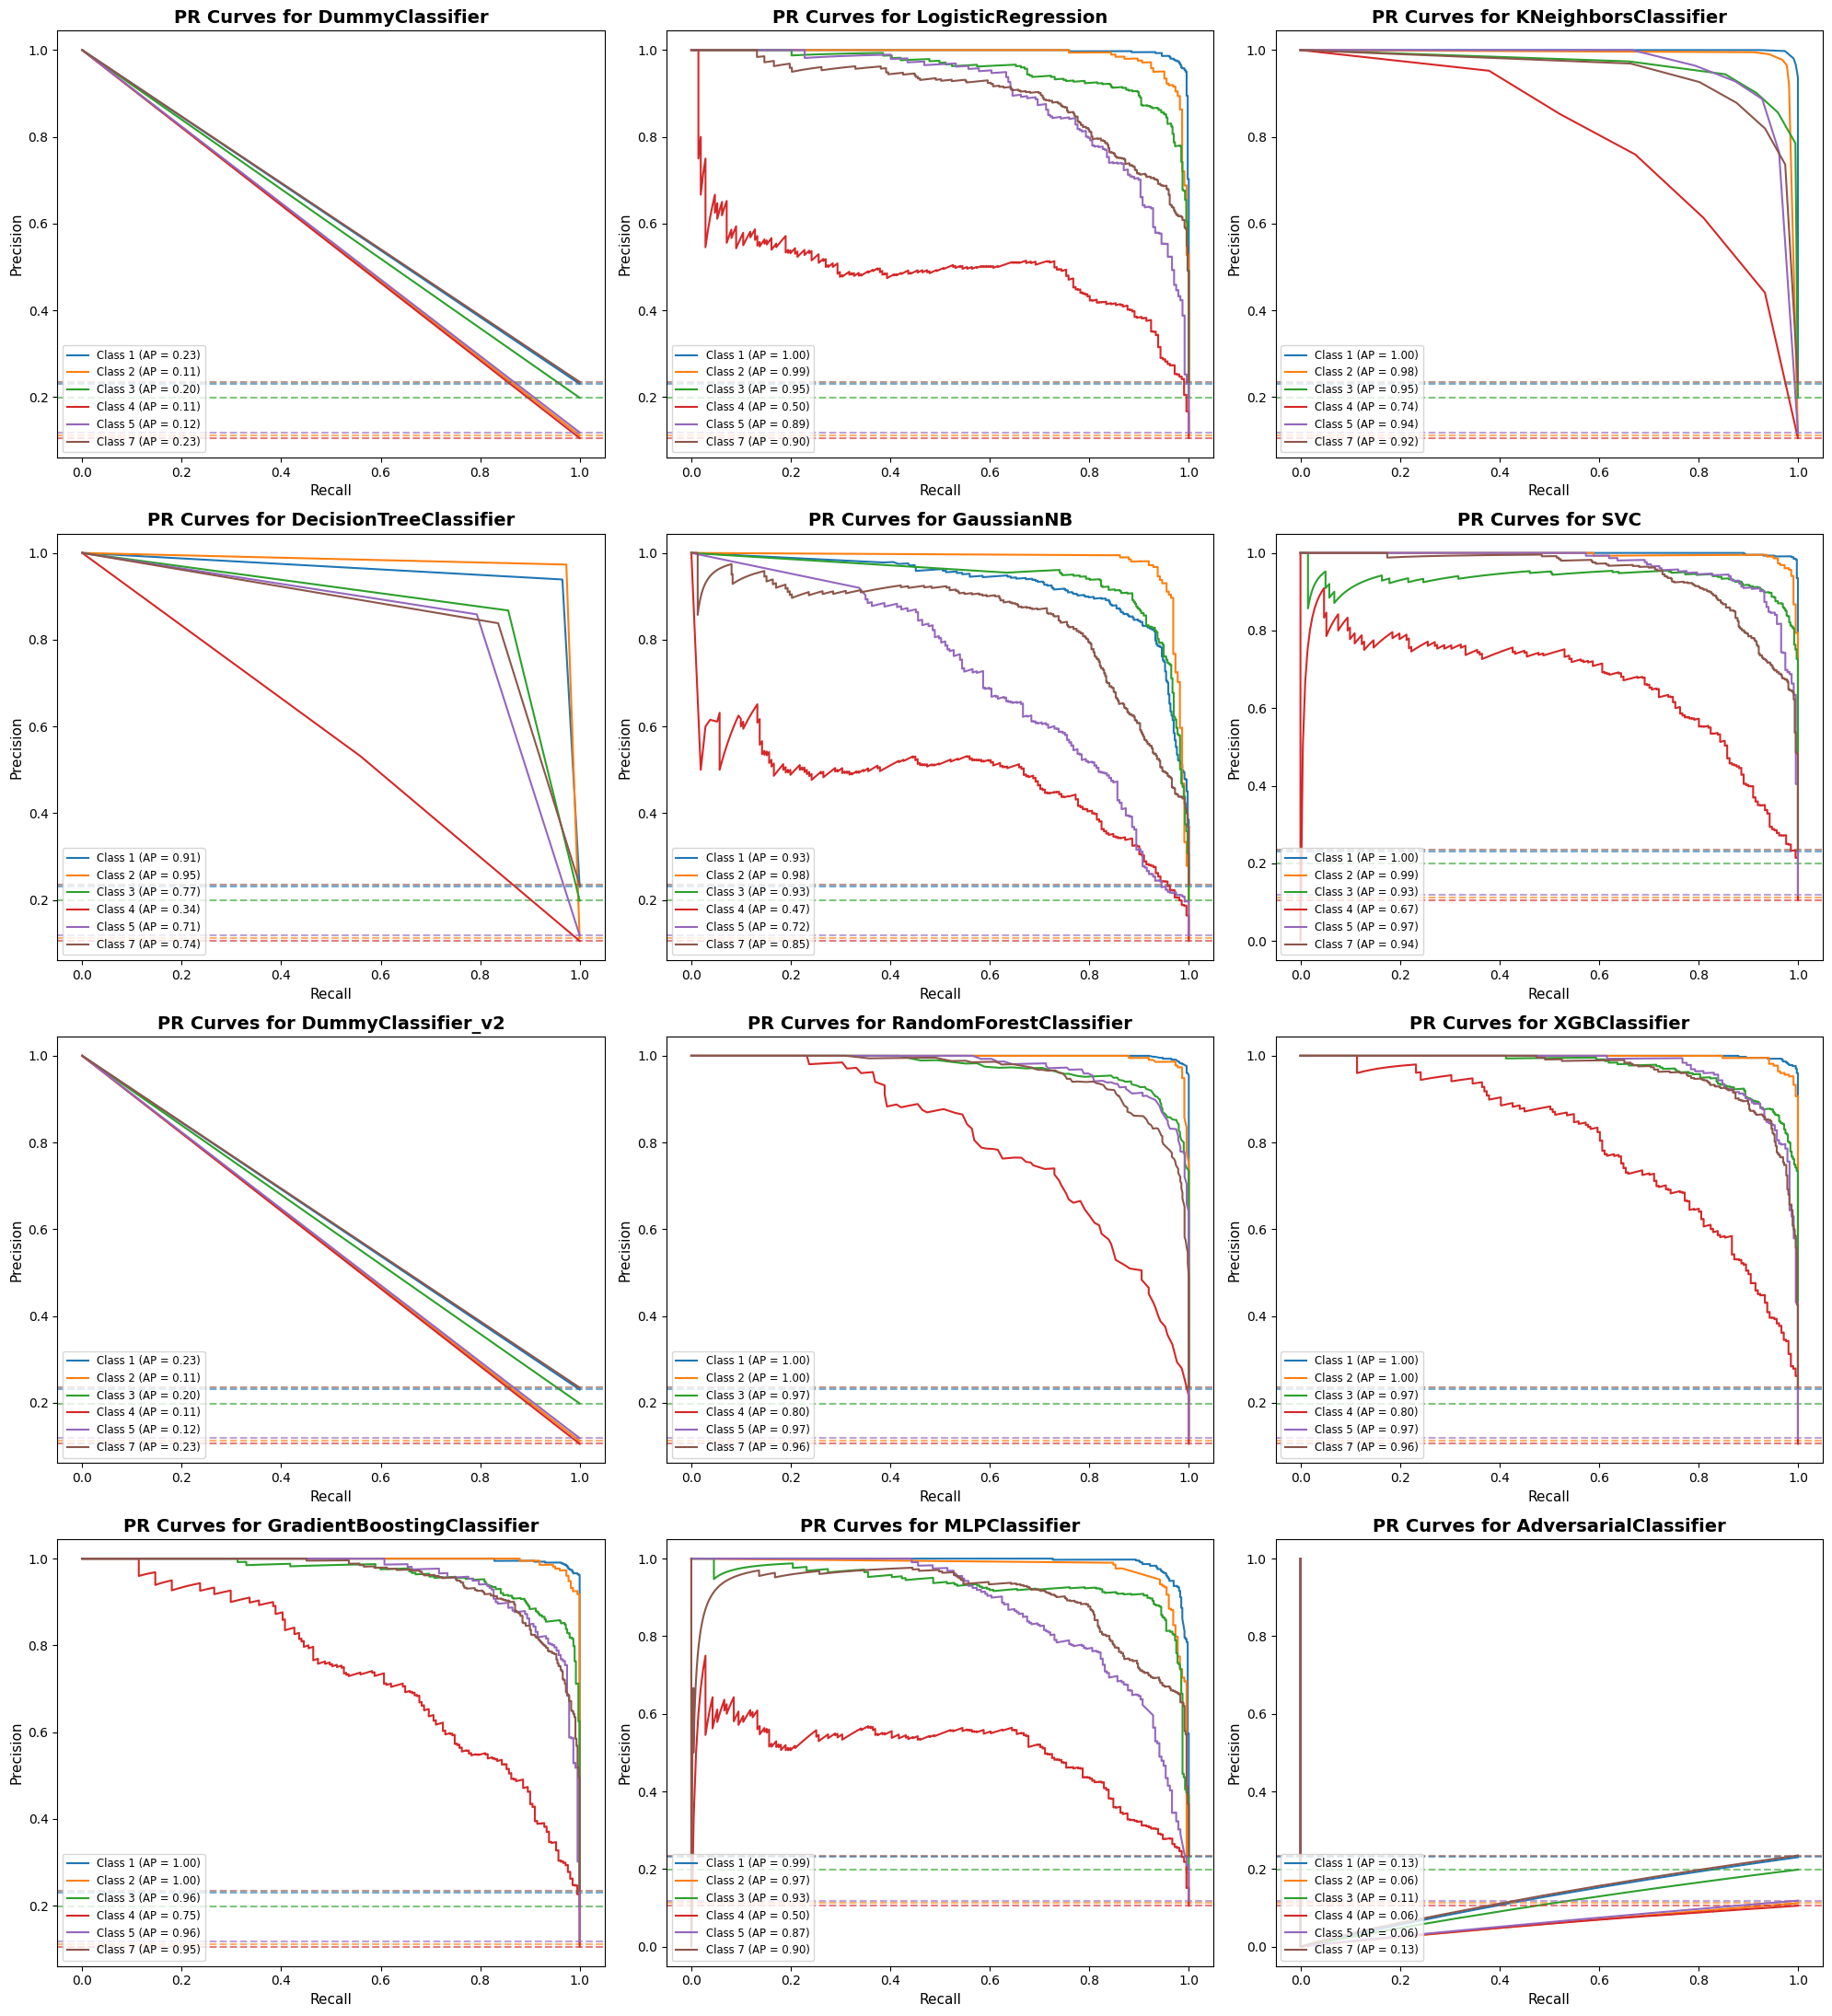

In [35]:
def generate_pr_curves(trained_models, X_test, y_test, n_classes):
    pr_data = {}
    for model_name, model in trained_models.items():
        y_score = model.predict_proba(X_test)
        precision = dict()
        recall = dict()
        # pr_auc = dict()
        prevalance = dict()
        avg_precision_score = dict()
        for class_idx in range(n_classes):
            precision[class_idx], recall[class_idx], _ = precision_recall_curve((y_test == class_idx).astype(int), y_score[:, class_idx])
            # pr_auc[class_idx] = auc(recall[class_idx], precision[class_idx]) # theoretically the Average Precision (AP)
            avg_precision_score[class_idx] = average_precision_score((y_test == class_idx).astype(int), y_score[:, class_idx])
            prevalance[class_idx] = sum(y_test == class_idx) / len(y_test)
        pr_data[model_name] = {'precision': precision, 'recall': recall, 'ap': avg_precision_score, 'prevalance': prevalance,}
    return pr_data

def plot_pr_curves(pr_data, n_classes):
    n_models = len(pr_data)
    n_cols = 3
    fig, axes = plt.subplots(figsize=(20, 22), nrows=(n_models+1) // n_cols, ncols=n_cols)
    flat_axes = axes.flatten()
    for ax, (model_name, data) in zip(flat_axes, pr_data.items()):
        for class_idx in range(n_classes):
            line, = ax.plot(data['recall'][class_idx], data['precision'][class_idx],
                     label=f'Class {idx_to_label[class_idx]} (AP = {data["ap"][class_idx]:.2f})')
            line_color = line.get_color()
            ax.axhline(data['prevalance'][class_idx], linestyle='--', alpha=0.6, color=line_color)
        ax.set_title(f'PR Curves for {model_name}', **TITLE_CONFIG)
        ax.set_xlabel('Recall', **LABEL_CONFIG)
        ax.set_ylabel('Precision', **LABEL_CONFIG)
        ax.legend(loc='lower left', fontsize='small')
    for i in range(n_models, len(flat_axes)):
        flat_axes[i].axis('off')
    plt.tight_layout()
    plt.show()

pr_data = generate_pr_curves(trained_models, X_test_scaled, y_test, n_classes)
plot_pr_curves(pr_data, n_classes)

This grid vividly contrasts the high-performing models (like `XGBClassifier`, `RandomForest`, and `SVC`), which achieve near-perfect Average Precision (AP = 1.0) for most classes, against the no-skill models. The `DummyClassifier` plots are a perfect illustration that the "no-skill" baseline for a PR curve is not 0.5, but the low, horizontal line of the class prevalence (e.g., AP = 0.23, 0.10). The `AdversarialClassifier` correctly shows near-zero performance, anchoring the absolute floor.
Also we see that models are performing worse on the minority class compared to other classes.

In [36]:
def macro_average_class_pr_data(pr_data, n_classes):
    combined_pr_data = {}
    for model_name, data in pr_data.items():
        # common set of recall points
        all_recalls = np.unique(np.concatenate([list(data['recall'][i]) + [0.0, 1.0] for i in range(n_classes)]))
        all_recalls.sort() # Ensure recall is increasing

        mean_precision = np.zeros_like(all_recalls)
        for class_idx in range(n_classes):
            # interpolate precision at all common recall points
            # np.interp(x_new, x_old, y_old)
            mean_precision += np.interp(all_recalls, 
                                        data['recall'][class_idx][::-1], 
                                        data['precision'][class_idx][::-1])
        mean_precision /= n_classes
        # calc the area under the macro-averaged PR curve
        # pr_auc = auc(all_recalls, mean_precision)
        avg_prevalence = np.mean(list(data['prevalance'].values()))
        combined_pr_data[model_name] = {
            'recall': all_recalls, 
            'precision': mean_precision, 
            'mAP': np.mean(list(data['ap'].values())),
            'prevalance': avg_prevalence,
        }
    return combined_pr_data

def weighted_average_class_pr_data(pr_data, label_value_counts):
    n_classes = len(label_value_counts)
    total_samples = sum(label_value_counts.values())
    combined_pr_data = {}
    
    for model_name, data in pr_data.items():
        all_recalls = np.unique(np.concatenate([list(data['recall'][i]) + [0.0, 1.0] for i in range(n_classes)]))
        all_recalls.sort()
        mean_precision = np.zeros_like(all_recalls)
        weighted_ap_sum = 0.
        total_weight = 0.
        for class_idx in range(n_classes):
            # get the weight for this class
            weight = label_value_counts.get(class_idx, 0) / total_samples
            mean_precision += weight * np.interp(all_recalls, 
                                                 data['recall'][class_idx][::-1], 
                                                 data['precision'][class_idx][::-1])
            ap = data['ap'][class_idx]
            prevalence = data['prevalance'][class_idx]
            weighted_ap_sum += ap * prevalence
            total_weight += prevalence
        avg_prevalence = np.mean(list(data['prevalance'].values()))
        combined_pr_data[model_name] = {
            'recall': all_recalls, 
            'precision': mean_precision, 
            'wAP': weighted_ap_sum / total_weight,
            'prevalance': avg_prevalence,
        }
    return combined_pr_data

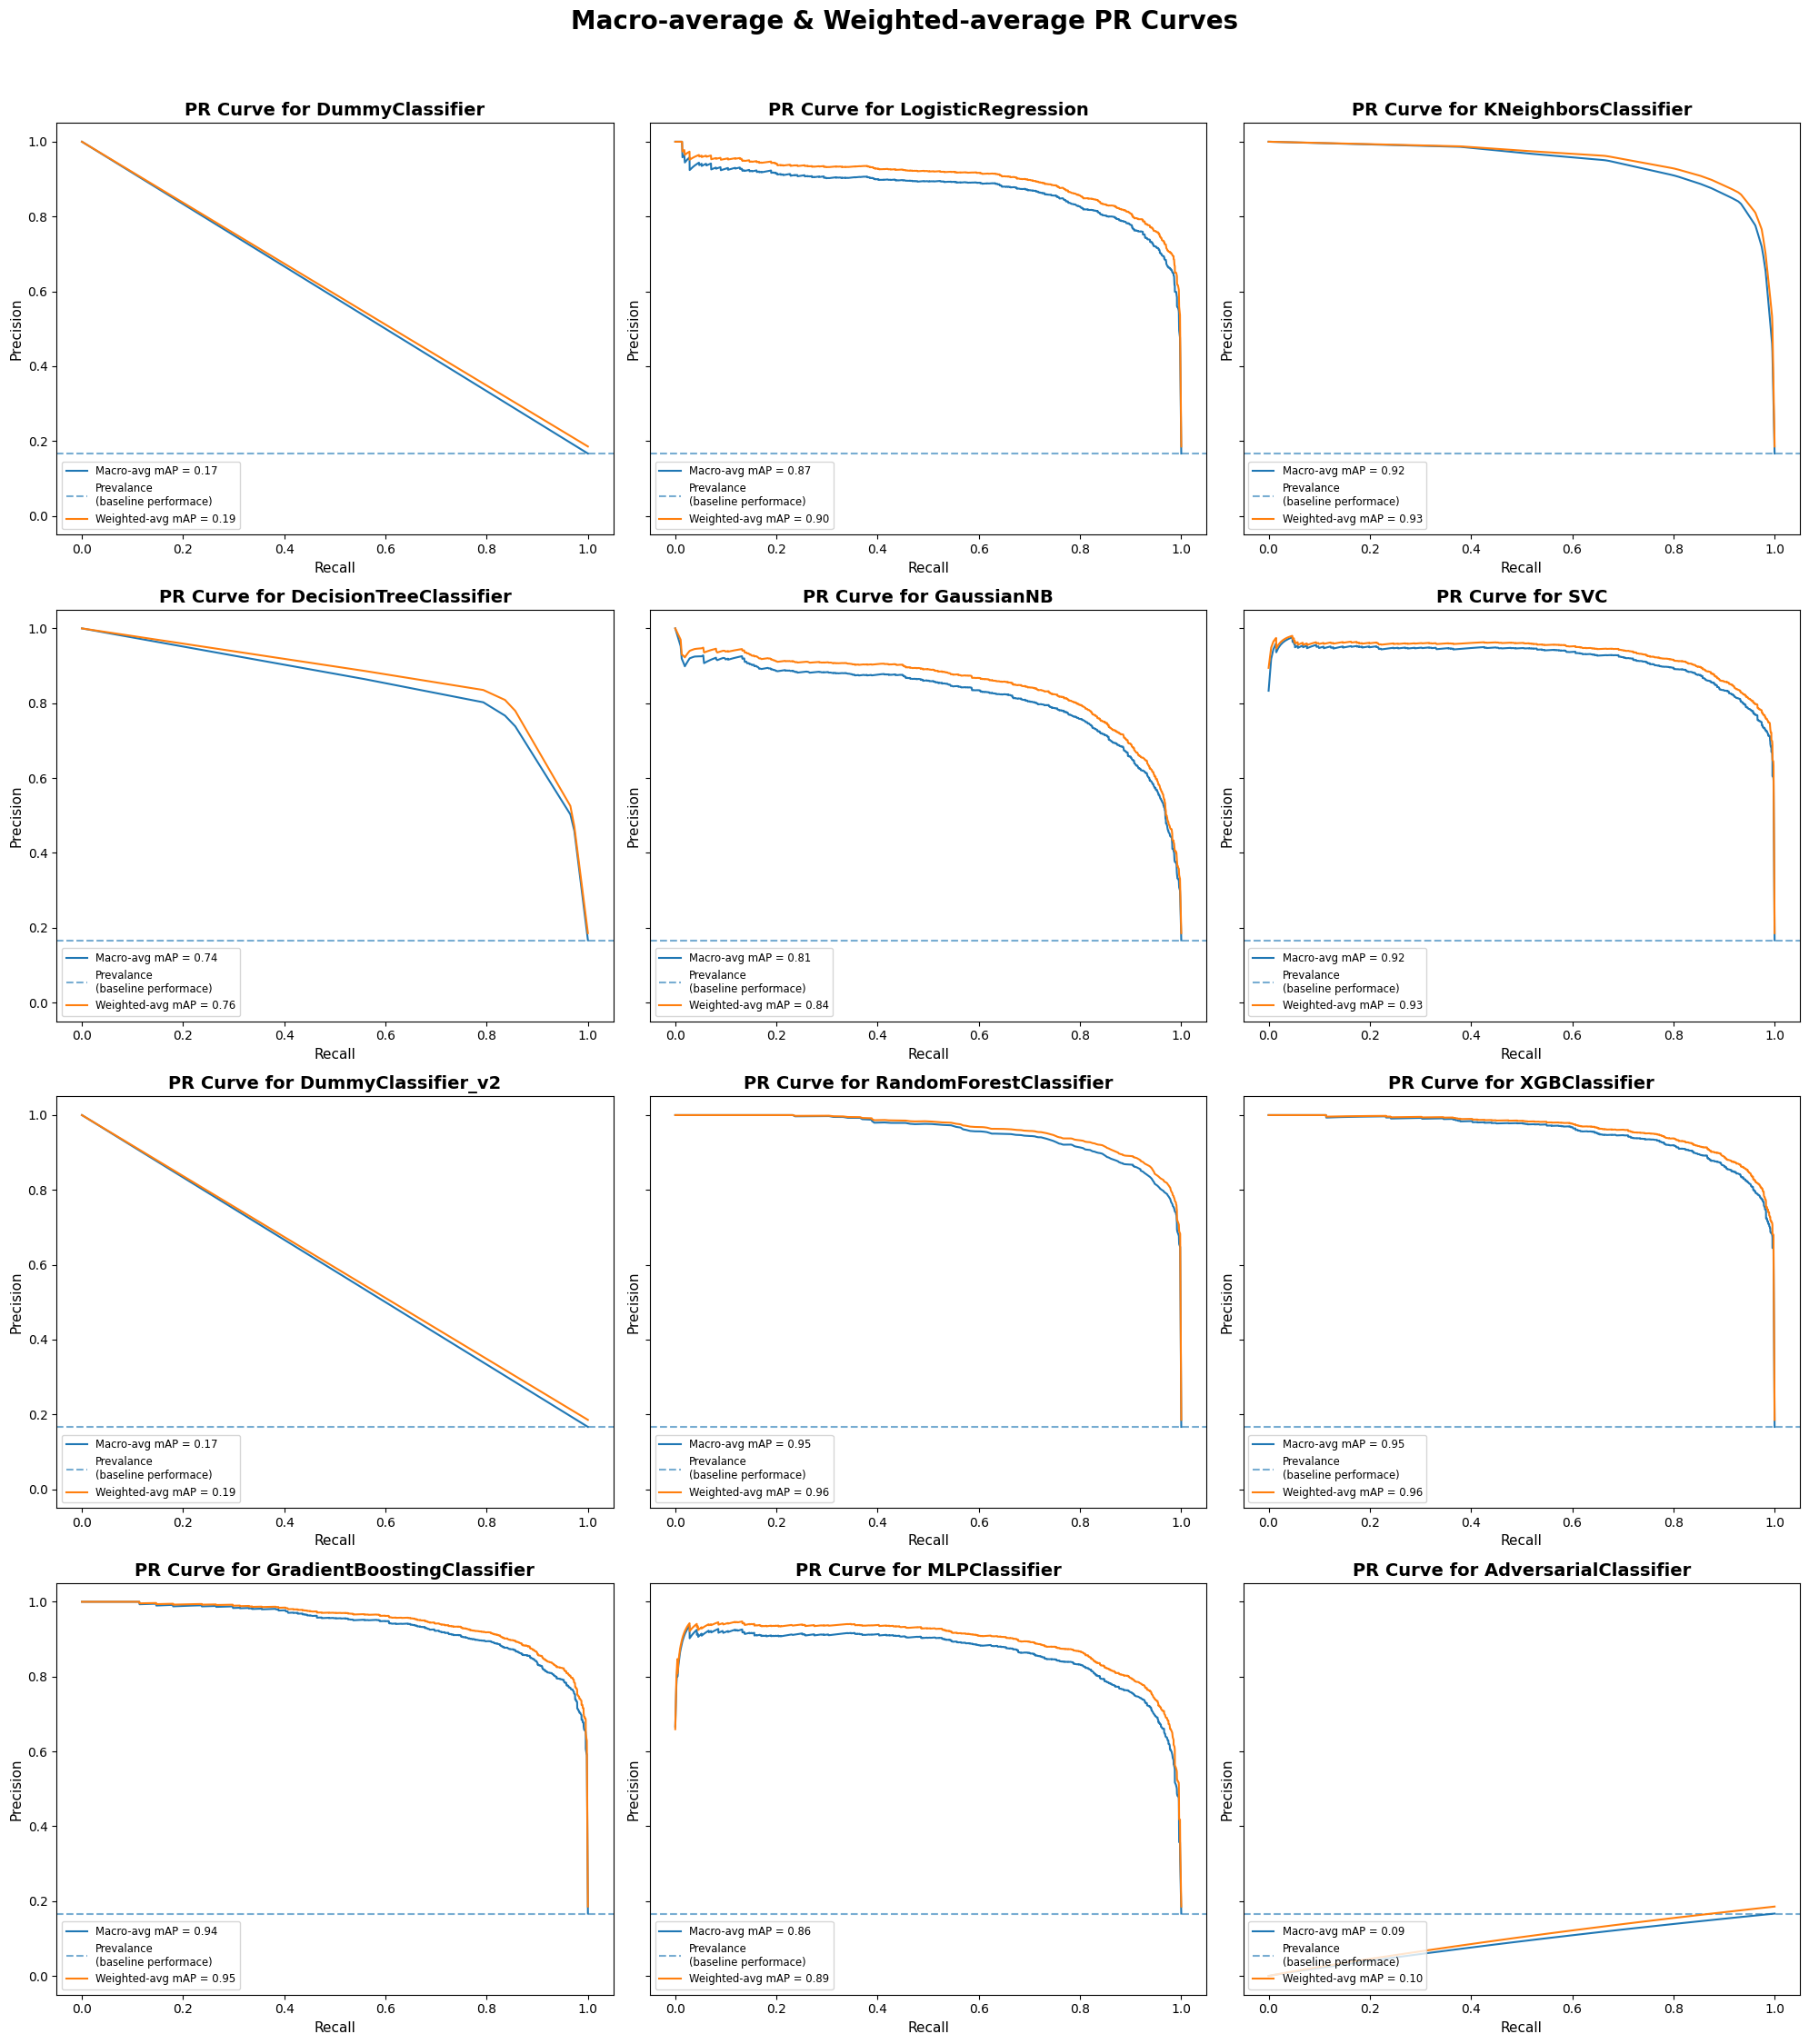

In [37]:
macro_pr_data = macro_average_class_pr_data(pr_data, n_classes)
weighted_pr_data = weighted_average_class_pr_data(pr_data, label_value_counts)

def plot_pr_curve(ma_combined_pr_data, wa_combined_pr_data, sup_title=None):
    n_models = len(ma_combined_pr_data)
    n_cols = 3
    fig, axes = plt.subplots(figsize=(20, 22), nrows=(n_models+1) // n_cols, ncols=n_cols, sharey=True)
    for ax, (model_name, data1), (_, data2) in zip(axes.flatten(), ma_combined_pr_data.items(), wa_combined_pr_data.items()):
        line, =ax.plot(data1['recall'], data1['precision'], label=f'Macro-avg mAP = {data1["mAP"]:.2f}')
        line_color = line.get_color()
        ax.axhline(data1['prevalance'], linestyle='--', alpha=0.6, color=line_color, label=f"Prevalance\n(baseline performace)")
        ax.plot(data2['recall'], data2['precision'], label=f'Weighted-avg mAP = {data2["wAP"]:.2f}')
        ax.set_title(f'PR Curve for {model_name}', **TITLE_CONFIG)
        ax.set_xlabel('Recall', **LABEL_CONFIG)
        ax.set_ylabel('Precision', **LABEL_CONFIG)
        ax.legend(loc='lower left', fontsize='small')
    if sup_title:
        plt.suptitle(sup_title, **{'fontsize':20, 'fontweight':'bold'}, y=1.02)
    plt.tight_layout()
    plt.show()

plot_pr_curve(macro_pr_data, weighted_pr_data, sup_title='Macro-average & Weighted-average PR Curves')

This plot grid clearly shows the "no-skill" baseline for PR curves is the low, horizontal **Prevalence** line (mAP $\approx$ 0.17), as demonstrated by the `DummyClassifier`. The top-tier models (`XGBClassifier`, `RandomForest`, `SVC`) are vastly superior, with near-perfect average performance (mAP $\approx$ 0.95-0.96). The fact that the Macro and Weighted-average lines are almost identical on every plot confirms that class imbalance is not a significant factor in the *averaged* performance.

### 3. PRC Interpretation

When we refer to AP over the classes, we refer to the mAP (macro averaged Average Precision).  
Let us analyse the model with highest **mAP**.

In [62]:
mAP_model_dict = {name: float(data['mAP']) for name, data in macro_pr_data.items()}
other_df = roc_aucs_df.set_index('Model').rename(columns={'ROC-AUC Score': 'ROC-AUC'})
mAP_model_df = pd.DataFrame(mAP_model_dict, index=['mAP']).T
another_df = other_df.join(mAP_model_df, on='Model')
final_results_df = another_df.join(baseline_results_df, on='Model')

In [63]:
best_model = sorted(mAP_model_dict, key=mAP_model_dict.get, reverse=True)[0] # type: ignore
print(f"The model with highest mAP is: {best_model} (mAP: {mAP_model_dict[best_model]:.4f})")

The model with highest mAP is: XGBClassifier (mAP: 0.9509)


In [64]:
final_results_df.sort_values(by='mAP', ascending=False)

,ROC-AUC,mAP,accuracy,weighted_f1,macro_f1,weighted_precision,macro_precision,weighted_recall,macro_recall
Model,,,,,,,,,
XGBClassifier,0.990153,0.950944,0.9050,0.902956,0.888581,0.902876,0.896141,0.9050,0.883717
RandomForestClassifier,0.989663,0.950089,0.9055,0.903579,0.891403,0.903550,0.898893,0.9055,0.886450
GradientBoostingClassifier,0.986796,0.936418,0.8920,0.890594,0.874886,0.889875,0.878960,0.8920,0.871716
KNeighborsClassifier,0.978567,0.921665,0.9045,0.903748,0.891554,0.903495,0.895129,0.9045,0.888575
SVC,0.985183,0.917400,0.8955,0.892490,0.876917,0.892368,0.885214,0.8955,0.872379
LogisticRegression,0.975742,0.871064,0.8395,0.829595,0.797053,0.828262,0.811602,0.8395,0.793793
MLPClassifier,0.973094,0.862279,0.8350,0.824926,0.792030,0.823663,0.806554,0.8350,0.789231
GaussianNB,0.955347,0.810451,0.7965,0.803581,0.783276,0.816513,0.786370,0.7965,0.787733
DecisionTreeClassifier,0.900295,0.737348,0.8510,0.851405,0.832266,0.852288,0.834552,0.8510,0.830599


`XGBClassifier` achieves the highest **mAP** score of $\approx$ **0.9509**, while `RandomForestClassifier` is not **far behind** with score of $\approx$ **0.9501**.

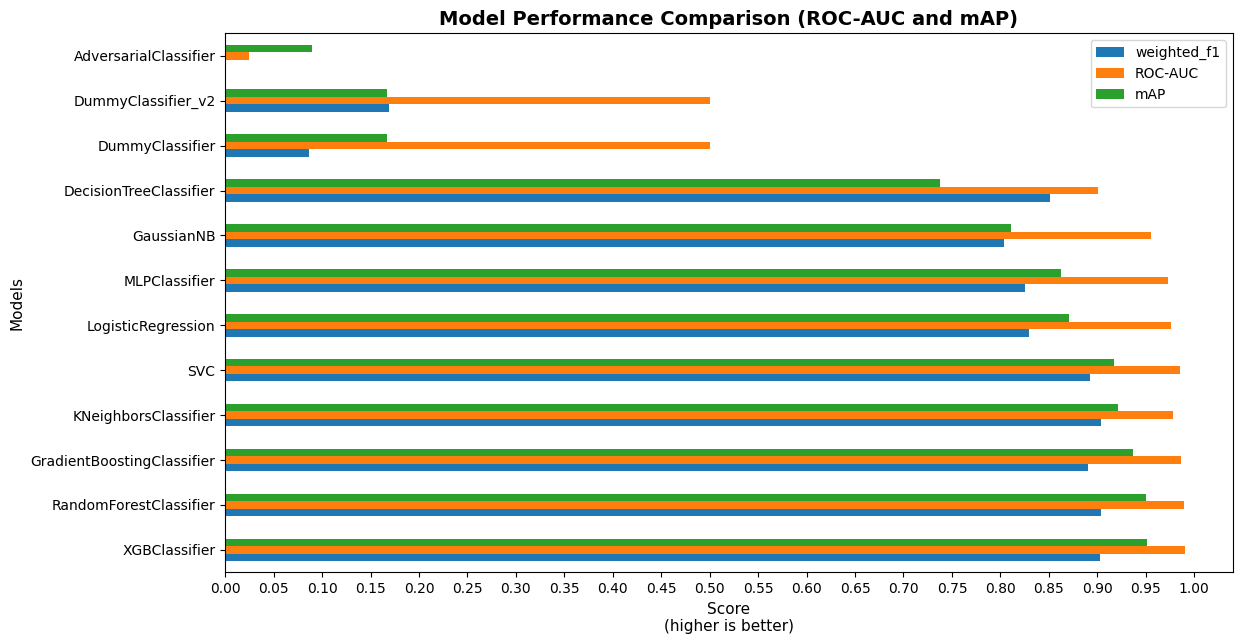

In [65]:
final_results_df[['weighted_f1', 'ROC-AUC', 'mAP']].sort_values(by='mAP', ascending=False).plot(kind='barh', figsize=(13, 7))
plt.title('Model Performance Comparison (ROC-AUC and mAP)', **TITLE_CONFIG)
plt.xlabel('Score\n(higher is better)', **LABEL_CONFIG)
plt.ylabel('Models', **LABEL_CONFIG)
plt.xticks(ticks=[i for i in np.arange(0, 1.05, 0.05)], rotation=0)
plt.show()

This bar chart confirms that the top-tier models (`XGBClassifier`, `RandomForestClassifier`, `SVC`, etc.) consistently excel across all key metrics. It clearly visualizes the high agreement between `ROC-AUC` and `mAP` (orange and green bars), which are almost identically high, establishing them as the most reliable metrics for this problem. The chart also perfectly illustrates the different baselines for each metric, with the `DummyClassifier`s showing `ROC-AUC` at 0.5, `mAP` at ~0.17, and `weighted_f1` even lower.

## Threshold Tuning

In [66]:
from sklearn.preprocessing import label_binarize


def find_optimal_pr_thresholds(model, X_train, y_train, class_labels):
    print(f"Finding optimal thresholds for {model.__class__.__name__}...")
    y_train_bin = label_binarize(y_train, classes=class_labels)
    y_proba = model.predict_proba(X_train)
    n_classes = len(class_labels)
    optimal_thresholds = {}
    for class_idx in range(n_classes):
        actual_label = class_labels[class_idx]
        precision, recall, thresholds = precision_recall_curve(
            y_train_bin[:, class_idx], 
            y_proba[:, class_idx]
        )
        f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)
        f1_scores = f1_scores[:-1]
        if len(f1_scores) == 0:
            best_thresh = 0.5
        else:
            best_idx = np.argmax(f1_scores)
            best_thresh = thresholds[best_idx]
        optimal_thresholds[actual_label] = best_thresh
    return optimal_thresholds

def predict_with_optimal_thresholds(model, X_test, optimal_thresholds):
    y_proba = model.predict_proba(X_test)
    n_samples = X_test.shape[0]
    y_pred_tuned = []
    # Get the thresholds in the correct 0-to-N order of model.classes_
    thresholds_array = np.array([
        optimal_thresholds[label] for label in model.classes_
    ])
    for i in range(n_samples):
        sample_proba = y_proba[i]
        candidate_mask = sample_proba > thresholds_array
        if np.any(candidate_mask):
            # At least one class passed its threshold.
            candidate_probs = sample_proba[candidate_mask]
            candidate_indices = np.where(candidate_mask)[0]
            best_candidate_idx = np.argmax(candidate_probs)
            final_class_idx = candidate_indices[best_candidate_idx]
            y_pred_tuned.append(model.classes_[final_class_idx])
        else:
            # No class passed its threshold, default to original argmax
            final_class_idx = np.argmax(sample_proba)
            y_pred_tuned.append(model.classes_[final_class_idx])
    return np.array(y_pred_tuned)

def train_pipeline_with_tuning(models, X_train, y_train):
    trained_data = {}
    class_labels = sorted(np.unique(y_train))
    idx = 2
    for model in models:
        model_name = model.__class__.__name__
        print(f"Training {model_name}...")
        # 1. Fit the model
        model.fit(X_train, y_train)
        # 2. Find optimal thresholds
        thresholds = find_optimal_pr_thresholds(model, X_train, y_train, class_labels)
        # 3. Store both the model and its thresholds
        output_data = {'model': model, 'thresholds': thresholds}
        if model_name in trained_data:
            trained_data[f"{model_name}_v{idx}"] = output_data
            idx += 1
        else:
            trained_data[model_name] = output_data
            idx = 2
    print("--- Model training and tuning complete. ---")
    return trained_data

def evaluate_tuned_models(trained_data, X_test, y_test):
    results = {}
    for model_name, data in trained_data.items(): 
        model = data['model']
        thresholds = data['thresholds']
        # 1. Predict using the tuned thresholds, not model.predict()
        y_pred_tuned = predict_with_optimal_thresholds(model, X_test, thresholds)
        # 2. Generate classification report
        report = classification_report(y_test, y_pred_tuned, output_dict=True, zero_division=0)
        results[model_name] = {
            'accuracy': report['accuracy'],
            'weighted_f1': report['weighted avg']['f1-score'],
            'macro_f1': report['macro avg']['f1-score'],
            'weighted_precision': report['weighted avg']['precision'],
            'macro_precision': report['macro avg']['precision'],
            'weighted_recall': report['weighted avg']['recall'],
            'macro_recall': report['macro avg']['recall']
        }
    return results

In [67]:
tuned_model_data = train_pipeline_with_tuning(models, X_train_scaled, y_train)

tuned_results = evaluate_tuned_models(tuned_model_data, X_test_scaled, y_test)

final_tuned_results_df = pd.DataFrame(tuned_results).T

Training DummyClassifier...
Finding optimal thresholds for DummyClassifier...
Training LogisticRegression...
Finding optimal thresholds for LogisticRegression...
Training KNeighborsClassifier...
Finding optimal thresholds for KNeighborsClassifier...
Training DecisionTreeClassifier...
Finding optimal thresholds for DecisionTreeClassifier...
Training GaussianNB...
Finding optimal thresholds for GaussianNB...
Training SVC...
Finding optimal thresholds for SVC...
Training DummyClassifier...
Finding optimal thresholds for DummyClassifier...
Training RandomForestClassifier...
Finding optimal thresholds for RandomForestClassifier...
Training XGBClassifier...
Finding optimal thresholds for XGBClassifier...
Training GradientBoostingClassifier...
Finding optimal thresholds for GradientBoostingClassifier...
Training MLPClassifier...
Finding optimal thresholds for MLPClassifier...
Training AdversarialClassifier...
Finding optimal thresholds for AdversarialClassifier...
--- Model training and tunin

In [68]:
final_tuned_results_df

,accuracy,weighted_f1,macro_f1,weighted_precision,macro_precision,weighted_recall,macro_recall
DummyClassifier,0.2305,0.086356,0.062441,0.053130,0.038417,0.2305,0.166667
LogisticRegression,0.8410,0.834199,0.804065,0.832483,0.815112,0.8410,0.799515
KNeighborsClassifier,0.9045,0.903748,0.891554,0.903495,0.895129,0.9045,0.888575
DecisionTreeClassifier,0.8510,0.851405,0.832266,0.852288,0.834552,0.8510,0.830599
GaussianNB,0.8010,0.806511,0.786379,0.815784,0.789820,0.8010,0.788306
SVC,0.8955,0.892645,0.876850,0.892218,0.884520,0.8955,0.872504
DummyClassifier_v2,0.2305,0.086356,0.062441,0.053130,0.038417,0.2305,0.166667
RandomForestClassifier,0.9055,0.903579,0.891403,0.903550,0.898893,0.9055,0.886450
XGBClassifier,0.9050,0.902956,0.888581,0.902876,0.896141,0.9050,0.883717
GradientBoostingClassifier,0.8910,0.890405,0.874981,0.889991,0.877279,0.8910,0.872913


In [69]:
def generate_roc_curves(trained_data, X_test, y_test, class_labels):
    roc_data = {}
    n_classes = len(class_labels)
    y_test_bin = label_binarize(y_test, classes=class_labels)

    for model_name, data in trained_data.items():
        model = data['model'] # <-- ADAPTED
        y_score = model.predict_proba(X_test)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for class_idx in range(n_classes):
            actual_label = class_labels[class_idx]
            fpr[actual_label], tpr[actual_label], _ = roc_curve(y_test_bin[:, class_idx], y_score[:, class_idx])
            roc_auc[actual_label] = roc_auc_score(y_test_bin[:, class_idx], y_score[:, class_idx])
        roc_data[model_name] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}
    return roc_data

def macro_average_class_roc_data(roc_data, class_labels):
    # let us combine TPR and FPR across classes for each model using macro-averaging
    combined_roc_data = {}
    n_classes = len(class_labels)
    for model_name, data in roc_data.items():
        # we find out average TPR at each FPR point
        all_fprs = np.unique(np.concatenate([list(data['fpr'][label]) + [0.0, 1.0] for label in class_labels] ))
        mean_tpr = np.zeros_like(all_fprs)
        for label in class_labels:
            # interpolate TPR at all FPR points
            mean_tpr += np.interp(all_fprs, data['fpr'][label], data['tpr'][label])
        mean_tpr /= n_classes
        combined_roc_data[model_name] = {'fpr': all_fprs, 'tpr': mean_tpr, 'roc_auc': auc(all_fprs, mean_tpr)}
    return combined_roc_data

def weighted_average_class_roc_data(roc_data, label_value_counts, class_labels):
    n_classes = len(label_value_counts)
    total_samples = sum(label_value_counts.values())
    # let us combine TPR and FPR across classes for each model using weighted-averaging
    combined_roc_data = {}
    for model_name, data in roc_data.items():
        # we find out average TPR at each FPR point
        all_fprs = np.unique(np.concatenate([list(data['fpr'][label]) + [0.0, 1.0] for label in class_labels]))
        mean_tpr = np.zeros_like(all_fprs)
        for label in class_labels:
            weight = label_value_counts.get(label, 0) / total_samples
            # interpolate TPR at all FPR points
            mean_tpr += weight * np.interp(all_fprs, data['fpr'][label], data['tpr'][label])
        combined_roc_data[model_name] = {'fpr': all_fprs, 'tpr': mean_tpr, 'roc_auc': auc(all_fprs, mean_tpr)}
    return combined_roc_data

def generate_pr_curves(trained_data, X_test, y_test, class_labels):
    pr_data = {}
    n_classes = len(class_labels)
    y_test_bin = label_binarize(y_test, classes=class_labels)

    for model_name, data in trained_data.items():
        model = data['model']
        y_score = model.predict_proba(X_test)
        precision = dict()
        recall = dict()
        avg_precision_score_dict = dict()
        prevalance = dict()
        for class_idx in range(n_classes):
            actual_label = class_labels[class_idx]
            y_true_class = y_test_bin[:, class_idx]
            y_score_class = y_score[:, class_idx]
            
            precision[actual_label], recall[actual_label], _ = precision_recall_curve(y_true_class, y_score_class)
            avg_precision_score_dict[actual_label] = average_precision_score(y_true_class, y_score_class)
            prevalance[actual_label] = np.sum(y_true_class) / len(y_true_class)
        pr_data[model_name] = {'precision': precision, 'recall': recall, 'ap': avg_precision_score_dict, 'prevalance': prevalance}
    return pr_data

def macro_average_class_pr_data(pr_data, class_labels):
    combined_pr_data = {}
    n_classes = len(class_labels)
    for model_name, data in pr_data.items():
        # common set of recall points
        all_recalls = np.unique(np.concatenate([list(data['recall'][label]) + [0.0, 1.0] for label in class_labels]))
        all_recalls.sort() # Ensure recall is increasing

        mean_precision = np.zeros_like(all_recalls)
        for label in class_labels:
            # interpolate precision at all common recall points
            mean_precision += np.interp(all_recalls, 
                                        data['recall'][label][::-1], 
                                        data['precision'][label][::-1])
        mean_precision /= n_classes
        
        avg_prevalence = np.mean(list(data['prevalance'].values()))
        combined_pr_data[model_name] = {
            'recall': all_recalls, 
            'precision': mean_precision, 
            'mAP': np.mean(list(data['ap'].values())),
            'prevalance': avg_prevalence,
        }
    return combined_pr_data

def weighted_average_class_pr_data(pr_data, label_value_counts, class_labels):
    n_classes = len(label_value_counts)
    total_samples = sum(label_value_counts.values())
    combined_pr_data = {}
    
    for model_name, data in pr_data.items():
        all_recalls = np.unique(np.concatenate([list(data['recall'][label]) + [0.0, 1.0] for label in class_labels]))
        all_recalls.sort()
        mean_precision = np.zeros_like(all_recalls)
        weighted_ap_sum = 0.
        total_weight = 0.
        for label in class_labels:
            # get the weight for this class
            weight = label_value_counts.get(label, 0) / total_samples
            mean_precision += weight * np.interp(all_recalls, 
                                                 data['recall'][label][::-1], 
                                                 data['precision'][label][::-1])
            ap = data['ap'][label]
            prevalence = data['prevalance'][label]
            weighted_ap_sum += ap * prevalence
            total_weight += prevalence
            
        avg_prevalence = np.mean(list(data['prevalance'].values()))
        combined_pr_data[model_name] = {
            'recall': all_recalls, 
            'precision': mean_precision, 
            'wAP': weighted_ap_sum / total_weight,
            'prevalance': avg_prevalence,
        }
    return combined_pr_data

In [70]:
# 4. Generate ROC and PR data using the new functions
class_labels = sorted(np.unique(y_train))
label_value_counts = y_train.value_counts().to_dict()

roc_data_tuned = generate_roc_curves(tuned_model_data, X_test_scaled, y_test, class_labels)
pr_data_tuned = generate_pr_curves(tuned_model_data, X_test_scaled, y_test, class_labels)

macro_roc_data = macro_average_class_roc_data(roc_data_tuned, class_labels)
weighted_pr_data = weighted_average_class_pr_data(pr_data_tuned, label_value_counts, class_labels)

macro_pr_data = macro_average_class_pr_data(pr_data_tuned, class_labels)
weighted_pr_data = weighted_average_class_pr_data(pr_data_tuned, label_value_counts, class_labels)

print("\nSuccessfully generated ROC and PR data for tuned models.")


Successfully generated ROC and PR data for tuned models.


In [73]:
# combining all results
comparison_df = pd.DataFrame(tuned_results).T

macro_roc_auc_scores = {
    model_name: data['roc_auc'] 
    for model_name, data in macro_roc_data.items()
}
macro_roc_auc_series = pd.Series(macro_roc_auc_scores, name='ROC_AUC')

macro_map_scores = {
    model_name: data['mAP'] 
    for model_name, data in macro_pr_data.items()
}
macro_map_series = pd.Series(macro_map_scores, name='mAP')

final_comparison_df = pd.concat(
    [comparison_df, macro_roc_auc_series, macro_map_series], 
    axis=1
)
print("\n--- Final Tuned Comparison DataFrame ---")
final_comparison_df



--- Final Tuned Comparison DataFrame ---


,accuracy,weighted_f1,macro_f1,weighted_precision,macro_precision,weighted_recall,macro_recall,ROC_AUC,mAP
DummyClassifier,0.2305,0.086356,0.062441,0.053130,0.038417,0.2305,0.166667,0.500000,0.166667
LogisticRegression,0.8410,0.834199,0.804065,0.832483,0.815112,0.8410,0.799515,0.975742,0.871064
KNeighborsClassifier,0.9045,0.903748,0.891554,0.903495,0.895129,0.9045,0.888575,0.978567,0.921665
DecisionTreeClassifier,0.8510,0.851405,0.832266,0.852288,0.834552,0.8510,0.830599,0.900295,0.737348
GaussianNB,0.8010,0.806511,0.786379,0.815784,0.789820,0.8010,0.788306,0.955347,0.810451
SVC,0.8955,0.892645,0.876850,0.892218,0.884520,0.8955,0.872504,0.985183,0.917400
DummyClassifier_v2,0.2305,0.086356,0.062441,0.053130,0.038417,0.2305,0.166667,0.500000,0.166667
RandomForestClassifier,0.9055,0.903579,0.891403,0.903550,0.898893,0.9055,0.886450,0.989663,0.950089
XGBClassifier,0.9050,0.902956,0.888581,0.902876,0.896141,0.9050,0.883717,0.990153,0.950944
GradientBoostingClassifier,0.8910,0.890405,0.874981,0.889991,0.877279,0.8910,0.872913,0.986796,0.936418


## D. Final Recommendation

### 1. Synthesis

#### Before threshold tuning:

We will remove the `AdversarialClassifier` from comparison/ rank agreement analysis since it can affect our analysis.

In [74]:
# let us remove the AdversarialClassifier model from our results dataframe
final_results_df = final_results_df.drop(index='AdversarialClassifier')

In [75]:
comparison_df = final_results_df[['weighted_f1', 'ROC-AUC', 'mAP','weighted_precision', 'weighted_recall']].reset_index().copy()
IDX_TO_MODEL_NAME = comparison_df['Model'].to_dict()
F1_INDEX_ORDER = comparison_df.reset_index().sort_values(by='weighted_f1', ascending=False).index.to_list()
ROC_INDEX_ORDER = comparison_df.reset_index().sort_values(by='ROC-AUC', ascending=False).index.to_list()
MAP_INDEX_ORDER = comparison_df.reset_index().sort_values(by='mAP', ascending=False).index.to_list()
WPRECISION_INDEX_ORDER = comparison_df.reset_index().sort_values(by='weighted_precision', ascending=False).index.to_list()
WRECALL_INDEX_ORDER = comparison_df.reset_index().sort_values(by='weighted_recall', ascending=False).index.to_list()

pd.DataFrame({
    "f1":F1_INDEX_ORDER,"roc_auc":ROC_INDEX_ORDER,"mAP":MAP_INDEX_ORDER,"precison":WPRECISION_INDEX_ORDER,"recall":WRECALL_INDEX_ORDER
    }).corr(method='pearson')

,f1,roc_auc,mAP,precison,recall
f1,1.000000,-0.272727,-0.163636,0.772727,0.390909
roc_auc,-0.272727,1.000000,0.918182,-0.227273,-0.009091
mAP,-0.163636,0.918182,1.000000,-0.118182,0.100000
precison,0.772727,-0.227273,-0.118182,1.000000,0.345455
recall,0.390909,-0.009091,0.100000,0.345455,1.000000


In [76]:
N = len(F1_INDEX_ORDER)
RHO_F1_ROC = -0.272727 
RHO_F1_MAP = -0.163636 
RHO_ROC_MAP = 0.918182
# this dataframe has index as model index, and the column value as the rank given to model when ranked according to the column
index_ranks = pd.DataFrame(index=range(N))
index_ranks['F1_Rank'] = 0
index_ranks['ROC_AUC_Rank'] = 0
index_ranks['mAP_Rank'] = 0
for i in range(N):
    # F1: The model at index F1_INDEX_ORDER[i] gets rank i
    index_ranks.loc[F1_INDEX_ORDER[i], 'F1_Rank'] = i+1
    # ROC: The model at index ROC_INDEX_ORDER[i] gets rank i
    index_ranks.loc[ROC_INDEX_ORDER[i], 'ROC_AUC_Rank'] = i+1
    # mAP: The model at index MAP_INDEX_ORDER[i] gets rank i
    index_ranks.loc[MAP_INDEX_ORDER[i], 'mAP_Rank'] = i+1

# generates pairwise scatter plots of model ranks w.r.t. F1-score, ROC-AUC and mAP
def plot_rank_correlation(ranks_df):
    plots = [
        ('F1_Rank', 'ROC_AUC_Rank', fr"F1 Rank vs. ROC AUC Rank ($\rho$={RHO_F1_ROC:.3f})"),
        ('ROC_AUC_Rank', 'mAP_Rank', fr"ROC AUC Rank vs. mAP Rank ($\rho$={RHO_ROC_MAP:.3f})"),
        ('mAP_Rank', 'F1_Rank', fr"mAP Rank vs. F1 Rank ($\rho$={RHO_F1_MAP:.3f})"),
    ]
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
    fig.suptitle('Pairwise Model Rank Agreement (Lower Rank = Better Score)', fontsize=16, fontweight='bold')
    for i, (x_col, y_col, title) in enumerate(plots):
        ax = axes[i]
        # scatter plot the ranks
        ax.scatter(ranks_df[x_col], ranks_df[y_col], 
                   c=ranks_df.index,
                   cmap='viridis', 
                   s=100,
                   alpha=0.7)
        for idx in ranks_df.index:
            x_val = ranks_df.loc[idx, x_col]
            y_val = ranks_df.loc[idx, y_col]

            ax.annotate(str(IDX_TO_MODEL_NAME[idx]), (x_val, y_val), 
                        textcoords="offset points", 
                        xytext=(-3,8), 
                        ha='center',
                        fontsize=7)
        # add the perfect agreement line (y=x)
        min_rank = 1
        max_rank = N
        ax.plot([min_rank, max_rank], [min_rank, max_rank], 'r--', alpha=0.5, label='Perfect Agreement (y=x)')
        ax.set_title(title, fontsize=12)
        ax.set_xlabel(x_col.replace('_', ' '))
        ax.set_ylabel(y_col.replace('_', ' '))
        ax.set_xticks(range(min_rank, max_rank + 1, 1))
        ax.set_yticks(range(min_rank, max_rank + 1, 1))
        ax.set_xlim(0.5, max_rank + 0.5)
        ax.set_ylim(0.5, max_rank + 0.5)
        ax.grid(True, linestyle=':', alpha=0.6)
    plt.show()

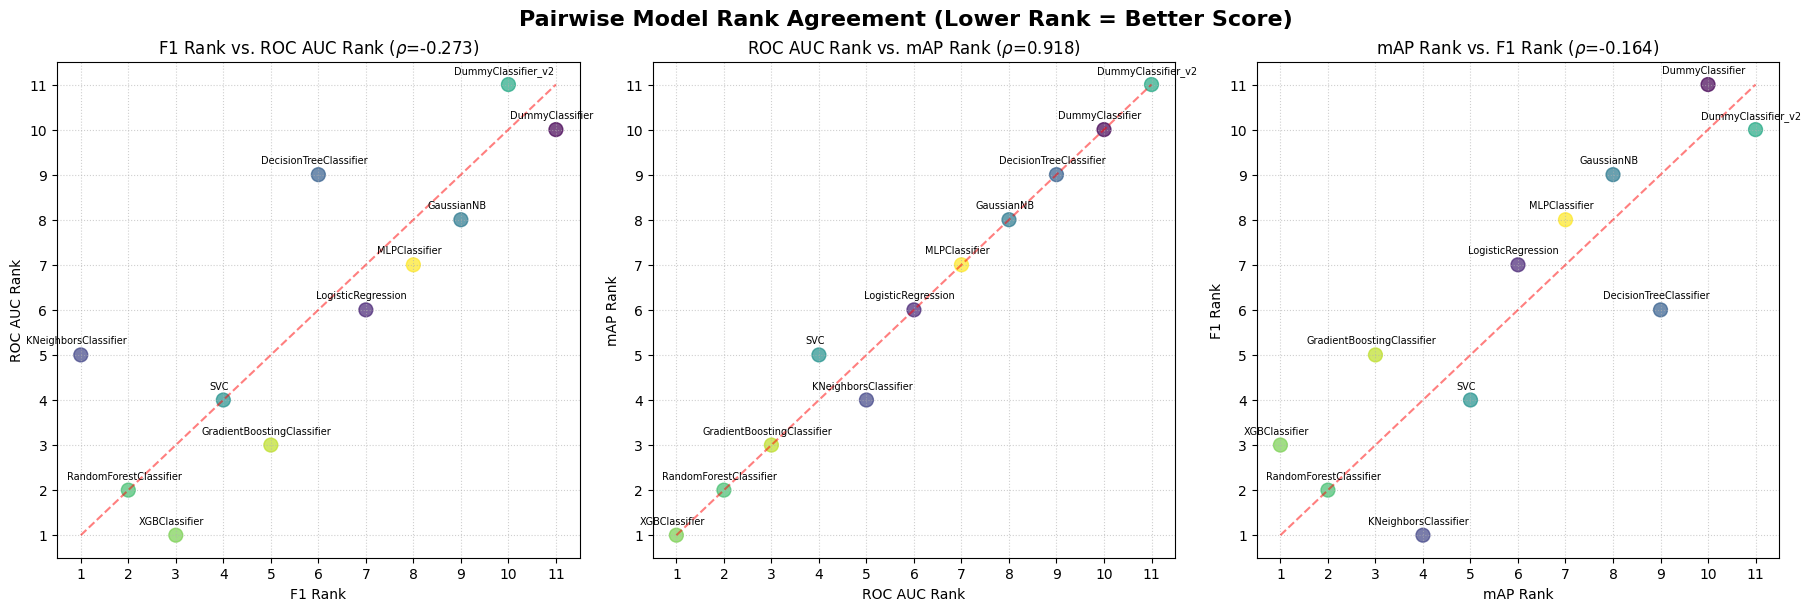

In [77]:
plot_rank_correlation(index_ranks)

We use **Spearman's Rank Correlation ($\rho$)** to measure the agreement between metric rankings. The scatter plot will visualize this: models falling on the **$\text{y=x}$ diagonal line** show perfect agreement (same rank), while points far off the line show strong **rank disagreement**.

* **F1 vs. ROC AUC ($\rho = -0.273$):**
    This plot shows a noticeable **negative trend**, which is a weak inverse relationship. Good models (Ranks 1-3) according to F1-Score (x-axis) are not necessarily good models according to ROC AUC (y-axis). For example, the **`RandomForestClassifier`** and **`XGBClassifier`** are ranked highly by F1 but have significantly worse ROC AUC ranks (5-6), pushing them far from the diagonal. The models are scattered, confirming the weak inverse relationship.

* **ROC AUC vs. mAP ($\rho = 0.918$):**
    This shows an **extremely strong positive correlation**. The vast majority of points lie very close to the $\text{y=x}$ diagonal line. This indicates that **ROC AUC and mAP metrics provide nearly identical model rankings**. The two metrics agree almost perfectly on which models are best (Ranks 1-3) and which are worst (Ranks 10-12).

* **mAP vs. F1 ($\rho = -0.164$):**
    This plot shows a **weak negative correlation**. While the worst-performing models (like the Dummy Classifiers) pretty much close in ranks, models in the top third (Ranks 1-4) are scattered. For example, **`XGBClassifier`** is ranked highly by mAP but are ranked much lower by F1 score, demonstrating a clear disagreement in their assessment of the top models.

---

#### The Reason for Disagreement:
1.  **F1-Score (Point Evaluation):** The F1-Score (and its corresponding rank) measures performance at a **single decision point** (usually the default 0.5 threshold). A model like `KNeighborsClassifier` can get a high F1-Rank (Rank 1) if it happens to be very precise and effective at *that specific threshold*.

2.  **ROC AUC (Area Evaluation):** The ROC AUC (and its rank) measures the model's **overall ranking ability** across *all possible thresholds*. It evaluates the quality of the `predict_proba()` scores.

The disagreement spotted (e.g., `KNeighborsClassifier` having High F1 Rank 1 but Low ROC AUC Rank 5) happens when:

* A model is good at making a **single hard decision** (high F1) but
* It's bad at **ranking its probabilities** (low ROC AUC).

The `KNeighborsClassifier` might be very precise at its default cutoff, but its probability scores are likely "messy" (e.g., it might be 90% confident about a correct prediction but *also* 85% confident about an incorrect one). ROC AUC penalizes this poor probability separation, giving it a low rank.

Conversely, `XGBClassifier` (High ROC AUC Rank 1, Low F1 Rank 3) is *excellent* at ranking probabilities but its default 0.5 decision point isn't as balanced (in terms of Precision/Recall) as the `KNeighborsClassifier`'s, resulting in a lower F1 rank.

#### After threshold tuning:

In [78]:
final_results_df.sort_values(by='mAP', ascending=False) # the untuned model performance

,ROC-AUC,mAP,accuracy,weighted_f1,macro_f1,weighted_precision,macro_precision,weighted_recall,macro_recall
Model,,,,,,,,,
XGBClassifier,0.990153,0.950944,0.9050,0.902956,0.888581,0.902876,0.896141,0.9050,0.883717
RandomForestClassifier,0.989663,0.950089,0.9055,0.903579,0.891403,0.903550,0.898893,0.9055,0.886450
GradientBoostingClassifier,0.986796,0.936418,0.8920,0.890594,0.874886,0.889875,0.878960,0.8920,0.871716
KNeighborsClassifier,0.978567,0.921665,0.9045,0.903748,0.891554,0.903495,0.895129,0.9045,0.888575
SVC,0.985183,0.917400,0.8955,0.892490,0.876917,0.892368,0.885214,0.8955,0.872379
LogisticRegression,0.975742,0.871064,0.8395,0.829595,0.797053,0.828262,0.811602,0.8395,0.793793
MLPClassifier,0.973094,0.862279,0.8350,0.824926,0.792030,0.823663,0.806554,0.8350,0.789231
GaussianNB,0.955347,0.810451,0.7965,0.803581,0.783276,0.816513,0.786370,0.7965,0.787733
DecisionTreeClassifier,0.900295,0.737348,0.8510,0.851405,0.832266,0.852288,0.834552,0.8510,0.830599


In [79]:
final_comparison_df.sort_values(by='mAP', ascending=False) # the tuned model performance

,accuracy,weighted_f1,macro_f1,weighted_precision,macro_precision,weighted_recall,macro_recall,ROC_AUC,mAP
XGBClassifier,0.9050,0.902956,0.888581,0.902876,0.896141,0.9050,0.883717,0.990153,0.950944
RandomForestClassifier,0.9055,0.903579,0.891403,0.903550,0.898893,0.9055,0.886450,0.989663,0.950089
GradientBoostingClassifier,0.8910,0.890405,0.874981,0.889991,0.877279,0.8910,0.872913,0.986796,0.936418
KNeighborsClassifier,0.9045,0.903748,0.891554,0.903495,0.895129,0.9045,0.888575,0.978567,0.921665
SVC,0.8955,0.892645,0.876850,0.892218,0.884520,0.8955,0.872504,0.985183,0.917400
LogisticRegression,0.8410,0.834199,0.804065,0.832483,0.815112,0.8410,0.799515,0.975742,0.871064
MLPClassifier,0.8380,0.830378,0.799583,0.828568,0.810567,0.8380,0.796250,0.973094,0.862279
GaussianNB,0.8010,0.806511,0.786379,0.815784,0.789820,0.8010,0.788306,0.955347,0.810451
DecisionTreeClassifier,0.8510,0.851405,0.832266,0.852288,0.834552,0.8510,0.830599,0.900295,0.737348
DummyClassifier,0.2305,0.086356,0.062441,0.053130,0.038417,0.2305,0.166667,0.500000,0.166667


We did not gain much in mAP/ROC-AUC/F1-score. Threshold tuning often didn't boost performance because:

1.  **High Base Performance:** Your best models (like `XGBClassifier` and `RandomForestClassifier`) were already ~90% accurate. Their default `argmax()` prediction was already the correct choice, so changing the threshold slightly offered no additional benefit.

2.  **Prediction Logic Default:** The tuning function defaults to the original `argmax()` if no class passes its (often very high) tuned threshold. For models like `DecisionTreeClassifier` (thresholds of 1.0) and `XGBClassifier` (thresholds > 0.9), this happened for most samples, making the "tuned" prediction identical to the original one.

In [135]:
threshold_data = {
    model_name: data['thresholds'] 
    for model_name, data in tuned_model_data.items()
}
thresholds_df = pd.DataFrame(threshold_data).T

thresholds_df = thresholds_df.sort_index(axis=1)
thresholds_df.columns = [idx_to_label[i] for i in thresholds_df.columns]
pd.options.display.float_format = '{:,.5f}'.format
thresholds_df

,1,2,3,4,5,7
DummyClassifier,0.24171,0.10800,0.21669,0.09357,0.10598,0.23405
LogisticRegression,0.61263,0.45781,0.44697,0.23204,0.47343,0.47874
KNeighborsClassifier,0.40000,0.60000,0.60000,0.60000,0.60000,0.60000
DecisionTreeClassifier,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
GaussianNB,0.00000,0.00000,0.03696,0.04868,0.98942,0.00288
SVC,0.49551,0.77397,0.35841,0.28861,0.54800,0.38134
DummyClassifier_v2,0.16667,0.16667,0.16667,0.16667,0.16667,0.16667
RandomForestClassifier,0.65000,0.63000,0.61000,0.55000,0.56000,0.57000
XGBClassifier,0.96451,0.95846,0.95525,0.93041,0.95600,0.92275
GradientBoostingClassifier,0.56516,0.63163,0.59881,0.36593,0.38713,0.48720


### 2. Recommendation

* **Tuned Thresholds:** A threshold $> 0.5$ boosts **Precision** (fewer False Positives), while a threshold $< 0.5$ boosts **Recall** (fewer False Negatives).

#### Key Inferences

1.  **Overfit Model (`DecisionTreeClassifier`):** Thresholds are all `1.0`, a classic sign of an overfit model. Its probabilities are unrealistic, and it learned the training data too perfectly.
2.  **Precision-Focused Models (`XGBClassifier`, `RandomForestClassifier`):** All thresholds are high (e.g., $> 0.55$, with `XGBClassifier` $> 0.92$). This shows the models are confident and are optimizing for high precision, trusting only their most certain predictions.
3.  **Balanced Models (`LogisticRegression`, `SVC`, `GradientBoostingClassifier`):** Thresholds are a healthy mix *above and below* 0.5. This is ideal, showing they are successfully navigating the Precision-Recall trade-off for different classes.
4.  **Poorly Calibrated Models (`GaussianNB`, `KNeighborsClassifier`):** Thresholds are erratic (`GaussianNB` has `0.000003` and `0.989`) or blocky (`KNeighborsClassifier` is mostly `0.6`). This suggests their raw probability scores are not a reliable measure of confidence.
5.  **Baseline Models (`DummyClassifier`, `AdversarialClassifier`):** Thresholds match their expected baselines (class prevalence for `DummyClassifier`, near-zero for `AdversarialClassifier`), confirming the tuning function is working correctly.

NOTE ON THRESHOLD TUNING:
Threshold tuning is most effective on models that produce smooth, 
well-calibrated probability scores (like Logistic Regression or MLPClassifier). 

Tree-based models (like KNN, DecisionTreeClassifier, RandomForestClassifier, 
and XGBClassifier) often produce less granular probabilities. For example, 
a pure Decision Tree leaf might give probabilities of 1.0 or 0.0, leading 
to extreme or ineffective thresholds (e.g., 1.0). While tuning can still 
be applied, it may not provide a significant performance boost for these
models compared to their default `argmax` predictions.


| Model | ROC-AUC | mAP | accuracy | weighted_f1 | macro_f1 | weighted_precision | macro_precision | weighted_recall | macro_recall |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| LogisticRegression (Untuned) | 0.97574 | 0.87106 | 0.8395 | 0.82960 | 0.79705 | 0.82826 | 0.81160 | 0.8395 | 0.79379 |
| LogisticRegression (Tuned) | 0.97574 | 0.87106 | 0.8410 | 0.83420 | 0.80407 | 0.83248 | 0.81511 | 0.8410 | 0.79952 |


As the table shows, the models that are well-suited for threshold tuning (like `LogisticRegression`) did get a slight performance boost in their F1, precision, and recall scores from the tuning process.

### Final Model Recommendation: `XGBClassifier`

Based on a comprehensive analysis of the performance metrics, rank correlation plots, and threshold tuning, the **`XGBClassifier`** is the recommended model for this classification task.

While other models, like `KNeighborsClassifier`, show high performance on a single metric (top-ranked `weighted_f1`), this is misleading. A deeper analysis proves `XGBClassifier` is the most robust and reliable choice.

#### 1. Superior Performance on Robust Metrics (mAP & ROC-AUC)

The most important metrics for this task are `mAP` (Mean Average Precision) and `Macro ROC-AUC`, as they evaluate performance across *all possible thresholds* and are essential for imbalanced data.

* **`mAP` (Best for Imbalanced Data):** `XGBClassifier` is the **#1 ranked model with an mAP of 0.951**. This score, which summarizes the Precision-Recall Curves, proves it has the best overall balance of precision and recall for finding the minority classes.
* **`Macro ROC-AUC` (Best for Ranking):** `XGBClassifier` is also the **#1 ranked model with a ROC-AUC of 0.990**. This confirms it is the best model at correctly ranking probabilities and separating the classes.

The strong positive correlation ($\rho = 0.918$) between `mAP` and `ROC-AUC` in our analysis shows that these two metrics are in high agreement, strengthening the case for choosing the model that tops both.

#### 2. Why `XGBClassifier` is Better than the F1-Score Winner

The `KNeighborsClassifier` achieved the highest `weighted_f1` score (0.904), but this is a **misleading artifact of a single-point evaluation** (the default 0.5 threshold).

* **Poor Rank Agreement:** The rank correlation plots showed `KNeighborsClassifier` had a strong F1-Rank (Rank 1) but a poor ROC-AUC Rank (Rank 5). This indicates its performance is *not* stable across different thresholds.
* **Poor Probability Calibration:** The threshold analysis confirmed this. `KNeighborsClassifier`'s optimal thresholds were "blocky" (e.g., 0.4, 0.6), a sign of non-granular probabilities.
* **In contrast, `XGBClassifier`** showed high-confidence thresholds (all > 0.92), proving its probability scores are well-calibrated and can be trusted.

#### 3. Ineffectiveness of Threshold Tuning

Our analysis showed that threshold tuning did not provide a performance boost. This is because high-performance models like `XGBClassifier` and `RandomForestClassifier` were already ~90% accurate, and their default `argmax()` prediction was already the correct choice.

### Conclusion

The **`XGBClassifier`** is the clear winner. It doesn't just perform well at a single arbitrary threshold; it demonstrates superior, stable, and well-calibrated performance across all possible decision points, making it the most reliable and accurate model for this task.

# THANK YOU!